## High-z galaxies with Te measurements

# Strong line methods Analysis

In [68]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from astropy.visualization import hist
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
plt.rcParams.update({'font.size': 12})

## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

In [69]:
## Functions to calculate the error bars in the strong line methods
from lmfit import minimize, Parameters

def minimise_func(params,R,calib):
    return (calib(params['met'])-R)

def err_ratio(x,y,e_x,e_y):
    """ Formal Error of x/y """
    return x/y * np.sqrt((e_x/x)**2 + (e_y/y)**2)

def err_R23(x1,x2,x3,y,ex1,ex2,ex3,ey):
    """ Formal Error of (x1+x2+x3)/y """
    return 1/y*np.sqrt((ex1*ex1+ex2*ex2+ex3*ex3) + ey*ey/y**2*(x1+x2+x3)**2)

# MC paramters
MC_steps = 500
def perturbed_lines(f):
    np.random.seed()
    new_lines = {}
    for line in line_names:
        new_lines[line] = np.random.normal(f[line],f['e'+line])
    return new_lines

# Maiolino 2008

In [3]:
## Maiolino calibrations. ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval
err_calib = 0.10

def R23_Maiolino2008(met):
    """ From Maiolino+08
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        R23 ratio  ((F([OII]3727) + F([OIII]4959) + F([OIII]5007))/F(Hb))
    """
    c0,c1,c2,c3,c4 =  0.7462, -0.7149, -0.9401, -0.6154, -0.2524
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))
    
    
def OIII_5007_Hb_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in 12 + log (O/H) (has to be converted to 12 + log(O/H)- 8.69)
    Output:
    ------- 
        OIII5007 / H beta ratio 
    """
    c0,c1,c2,c3 =  0.1549, -1.5031, -0.9790, -0.0297
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def OII_3727_Hb_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        OII doublet / H beta ratio 
    """
    c0,c1,c2,c3,c4 = 0.5603, 0.0450, -1.8017, -1.8434, -0.6549
    return (10**polyval(met-8.69,(c0,c1,c2)))


def OIII_5007_OII_3727_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69 
    Output:
    ------- 
        OIII 5007 / OII doublet 
    """
    c0,c1,c2 = -0.2839, -1.3881, -0.3172
    return (10**polyval(met-8.69,(c0,c1,c2)))


def NeIII_3870_OII_3727_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        NeIII 3870 / OII doublet 
    """
    c0,c1,c2 = -1.2608, -1.0861, -0.1470
    return (10**polyval(met-8.69,(c0,c1,c2)))
    

def NII_6584_Ha_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        NII 6584 / Ha 
    """
    c0,c1,c2,c3,c4 = -0.7732, 1.2357, -0.2811, -0.7201, -0.3330    
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))
    

def OIII_5007_NII_6584_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        OIII 5007 / NII 6584 
    """
    c0,c1,c2,c3 = 0.4520, -2.6096, -0.7170, 0.1347 
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))    

### Minimising function

Problem: when there are two branched (e.g. R23) we will get both awsers and so the median metallicity will be completelly wrong.

Diagnostics where this is a problem: **R23,[OIII]/Hb, [OII]/Hb**
Approximate inflexion points: 8.0, 7.9, 8.7 (from fig. 5 Maiolino et al., 2008)

The highest metallicity in our sample is 8.5 (from the direct metallicity measurements).

**For now just use the low metallicity branch, but this is not quite right**

In [5]:
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')

R23_Maiolino08 = []
NII_Ha_Maiolino08 = []
OIII_Hb_Maiolino08 = []
O32_Maiolino08 = []
OII_Hb_Maiolino08 =[]
OIII_NII_Maiolino08 =[]
Ne_OII_Maiolino08 = []


for f in dered_fluxes:
    
    print('*******************',f['Name'],'*******************')
    params = Parameters()
    params.add('met', value=8.0, min=7.00, max=8.00+0.5) # low metallicity solution 8.00 + delta met of 0.5
    #params.add('met', value=8.0, min=8.00-0.5, max=9.2) # high metallicity solution

    ## R23
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    eR = err_R23(f['OIITot'],f['OIII4959'],f['OIII5007'],f['Hb'],f['eOIITot'],f['eOIII4959'],f['eOIII5007'],f['eHb'])
    if np.isfinite(R):
        fit = minimize(minimise_func, params,args=(R,R23_Maiolino2008))
        params.pretty_print()
        R23_Maiolino08.append(fit.params['met'].value)
        print('R23 metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        R23_Maiolino08.append(np.nan)
        print('No R23 metallicity')
        
                       
    ## NII/Ha
    R = f['NII6584']/f['Ha']
    eR = err_ratio(f['NII6584'],f['Ha'],f['eNII6584'],f['eHa'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Maiolino2008))
        NII_Ha_Maiolino08.append(fit.params['met'].value)
        print('NII/Ha metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        NII_Ha_Maiolino08.append(np.nan)
        print('No NII/Ha metallicity')                
    
                       
    ## OIII/Hb
    R = f['OIII5007']/f['Hb']
    eR = err_ratio(f['OIII5007'],f['Hb'],f['eOIII5007'],f['eHb'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.00, max=7.9+0.5) # low metallicity solution
        #params['met'].set(value=8.0, min=7.9-0.5, max=9.2) # high metallicity solution
        fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Maiolino2008))
        OIII_Hb_Maiolino08.append(fit.params['met'].value)
        print('OIII/Hb metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        OIII_Hb_Maiolino08.append(np.nan)
        print('No OIII/Hb metallicity')                
    
                       
    ## O32
    R = f['OIII5007']/f['OIITot']
    eR = err_ratio(f['OIII5007'],f['OIITot'],f['eOIII5007'],f['eOIITot'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Maiolino2008))
        O32_Maiolino08.append(fit.params['met'].value)
        print('O32 metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        O32_Maiolino08.append(np.nan)
        print('No O32 metallicity')
     
                       
    ## OII/Hb
    R = f['OIITot']/f['Hb']
    eR = err_ratio(f['OIITot'],f['Hb'],f['eOIITot'],f['eHb'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.00, max=8.7+0.5) # low metallicity solution
        #params['met'].set(value=8.0, min=8.7-0.5, max=9.2) # high metallicity solution
        fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Maiolino2008))
        OII_Hb_Maiolino08.append(fit.params['met'].value)
        print('OII/Hb metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        OII_Hb_Maiolino08.append(np.nan)
        print('No OII/Hb metallicity')
               
                       
    ## OIII/NII
    R = f['OIII5007']/f['NII6584']
    eR = err_ratio(f['OIII5007'],f['NII6584'],f['eOIII5007'],f['eNII6584'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Maiolino2008))
        OIII_NII_Maiolino08.append(fit.params['met'].value)
        print('OIII/NII metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        OIII_NII_Maiolino08.append(np.nan)
        print('No OIII/NII metallicity')
    
    
    ## Ne/OII
    R = f['NeIII3869']/f['OIITot']
    eR = err_ratio(f['NeIII3869'],f['OIITot'],f['eNeIII3869'],f['eOIITot'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Maiolino2008))
        Ne_OII_Maiolino08.append(fit.params['met'].value)
        print('Ne/OII metallicity %0.2f +/- %0.2f. %s'%(fit.params['met'].value,fit.params['met'].stderr,fit.message))
    else:
        Ne_OII_Maiolino08.append(np.nan)
        print('No Ne/OII metallicity')                               


('*******************', 'CSWA20', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8        7      8.5     None     True     None     None
R23 metallicity 7.61 +/- inf. Fit succeeded.
NII/Ha metallicity 7.86 +/- inf. Fit succeeded.
OIII/Hb metallicity 8.13 +/- inf. Fit succeeded.
O32 metallicity 7.32 +/- inf. Fit succeeded.
OII/Hb metallicity 8.00 +/- inf. Fit succeeded.
OIII/NII metallicity 7.96 +/- inf. Fit succeeded.
Ne/OII metallicity 7.40 +/- inf. Fit succeeded.
('*******************', 'USD-12539', '*******************')
No R23 metallicity
NII/Ha metallicity 8.22 +/- inf. Fit succeeded.
OIII/Hb metallicity 8.17 +/- inf. Fit succeeded.
O32 metallicity 7.95 +/- inf. Fit succeeded.
OII/Hb metallicity 8.20 +/- inf. Fit succeeded.
OIII/NII metallicity 8.22 +/- inf. Fit succeeded.
Ne/OII metallicity 8.10 +/- inf. Fit succeeded.
('*******************', 'Abell_860_359', '*******************')
Name     Value      Min      Max   Stder

### Get error bars on this. 

Use MC as usual, since I have no better idea.

<IPython.core.display.Javascript object>


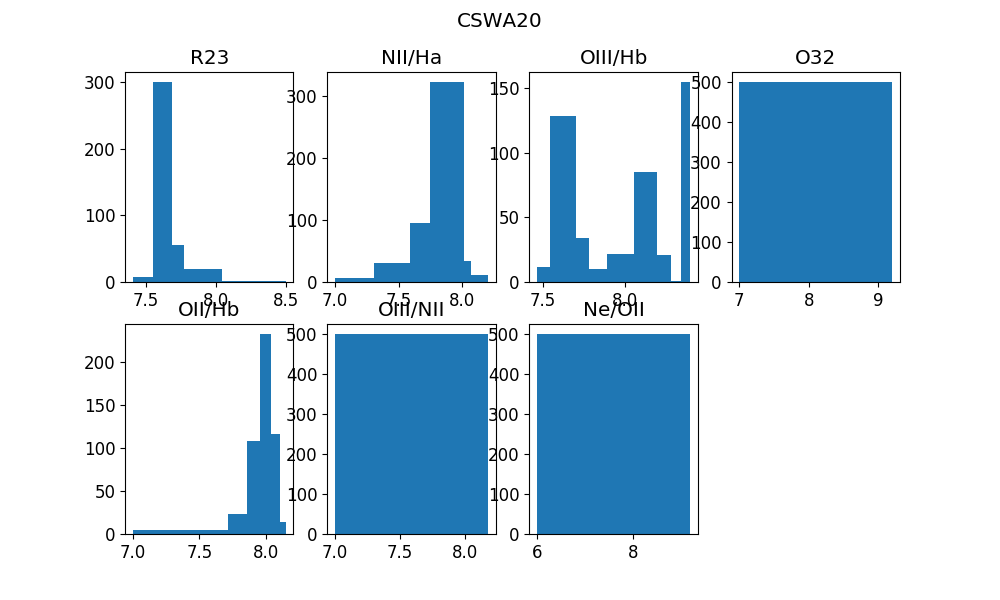

<IPython.core.display.Javascript object>


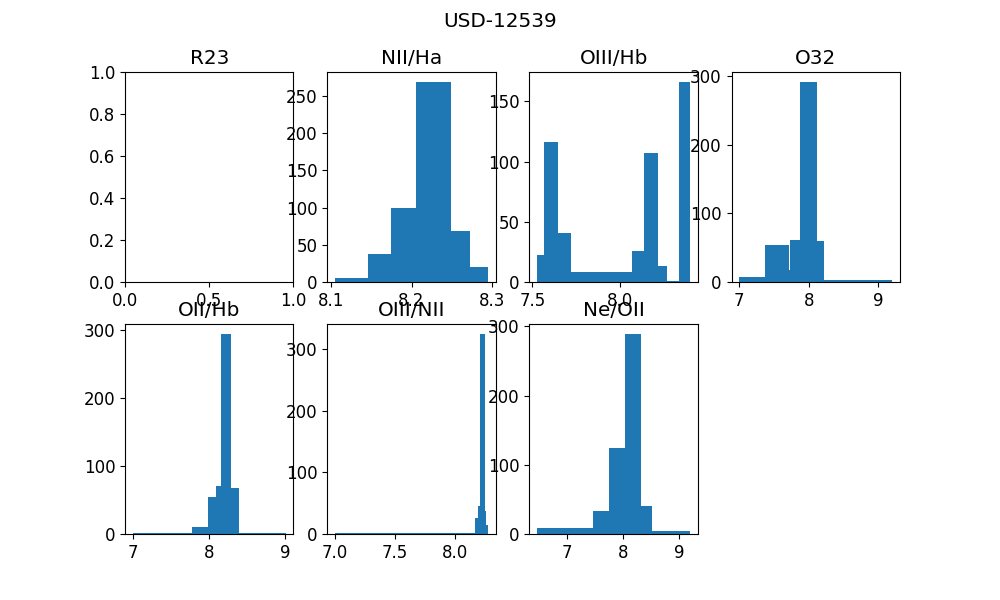

R23 not available


<IPython.core.display.Javascript object>


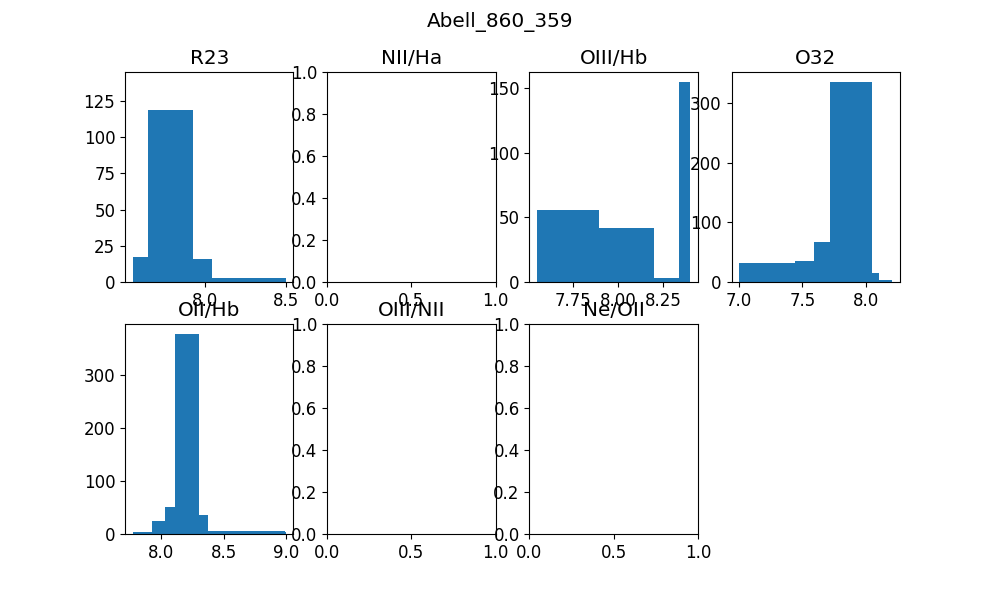

NII_Ha not available
OIII_NII not available
Ne_OII not available


<IPython.core.display.Javascript object>


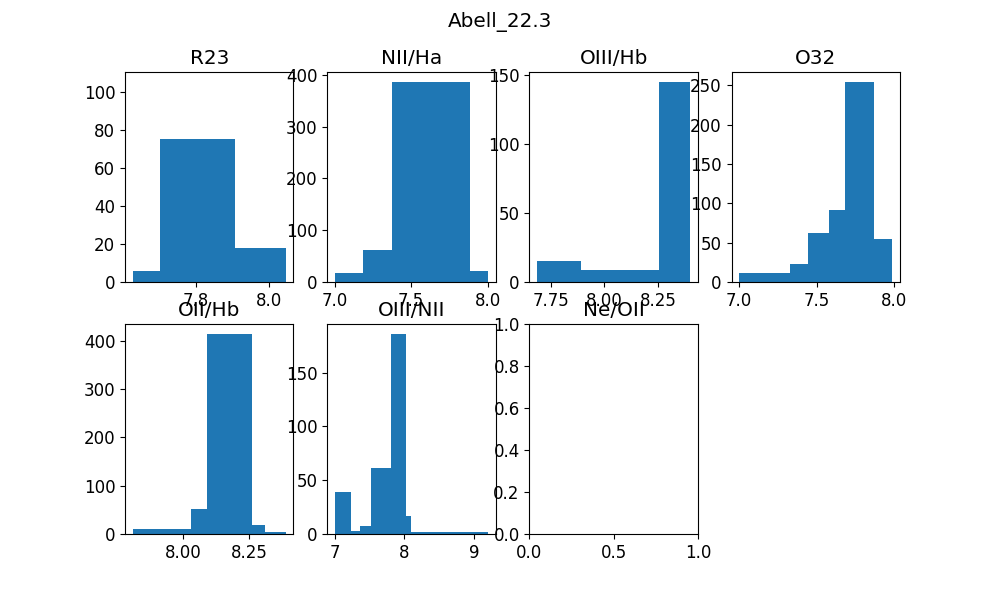

Ne_OII not available


<IPython.core.display.Javascript object>


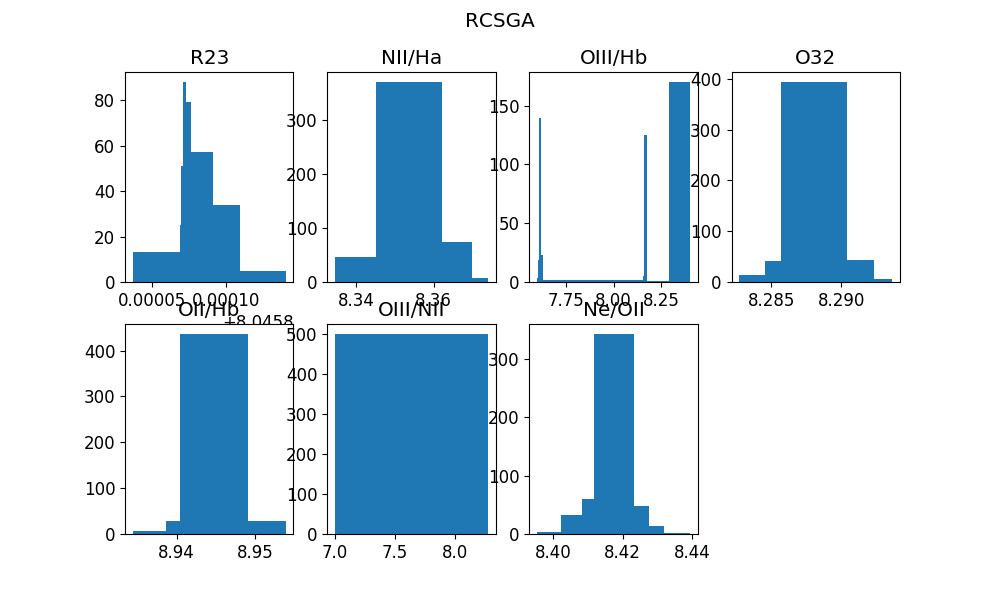

<IPython.core.display.Javascript object>


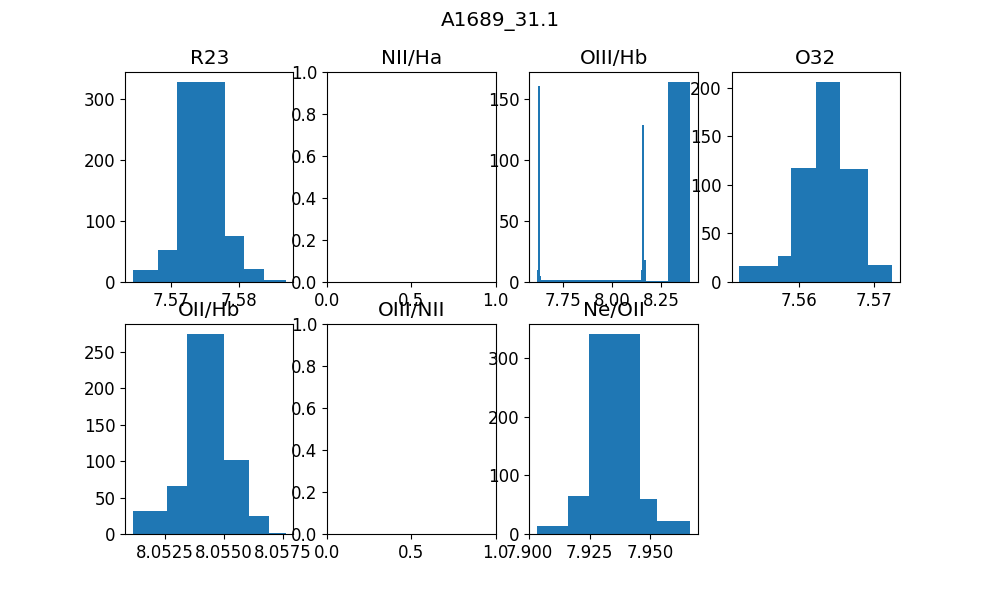

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


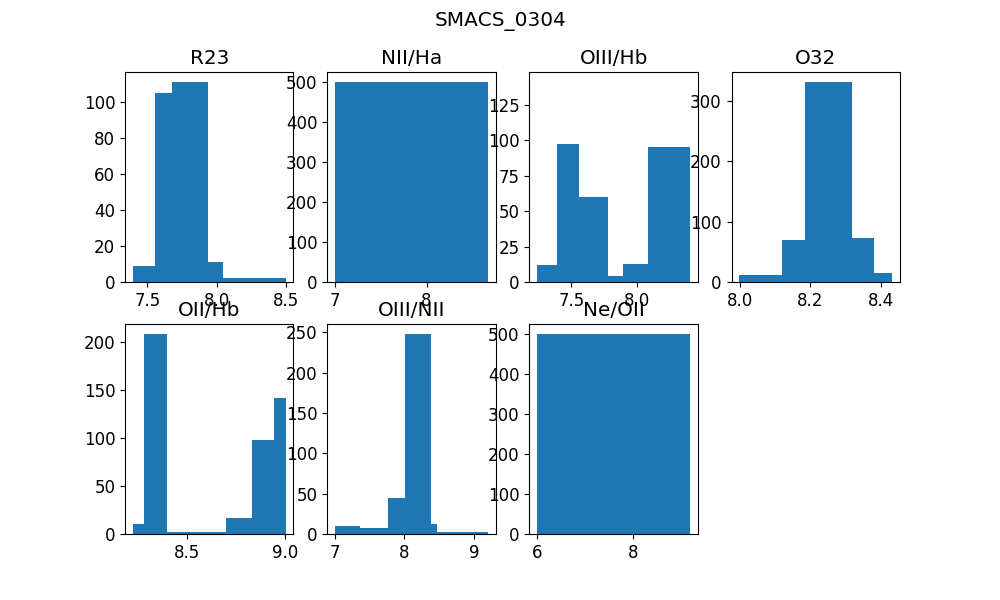

<IPython.core.display.Javascript object>


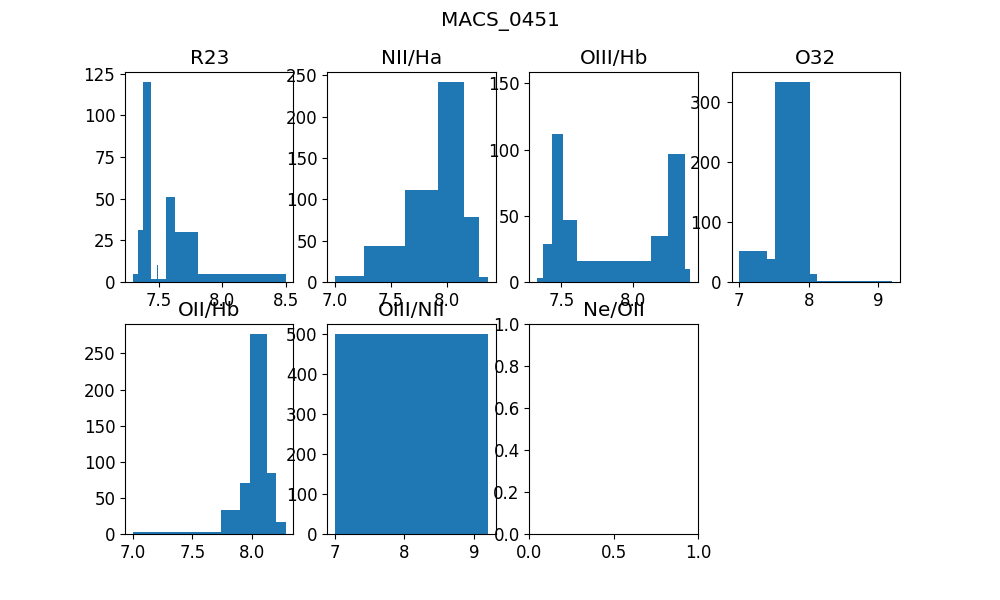

Ne_OII not available


<IPython.core.display.Javascript object>


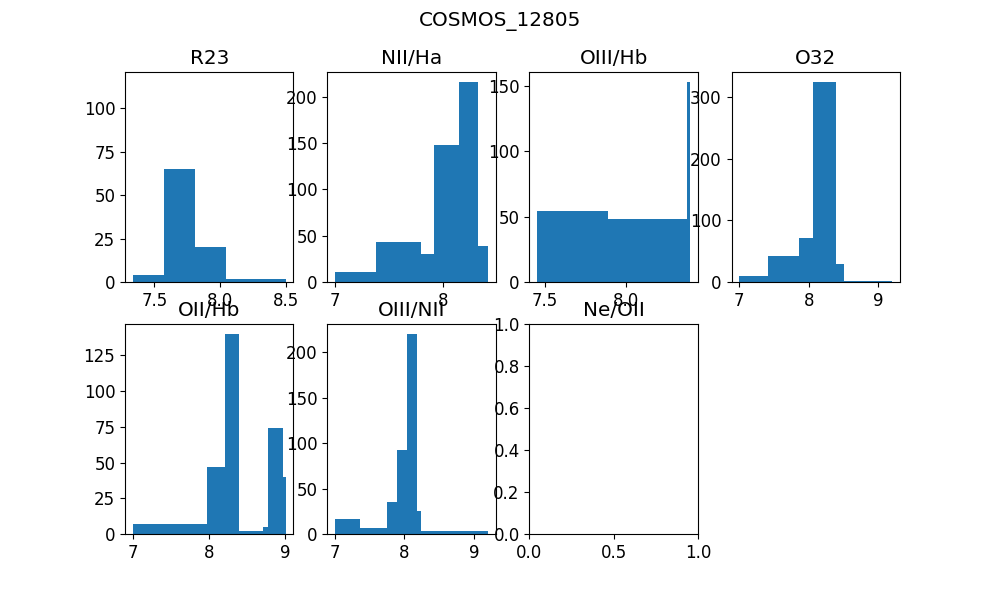

Ne_OII not available


<IPython.core.display.Javascript object>


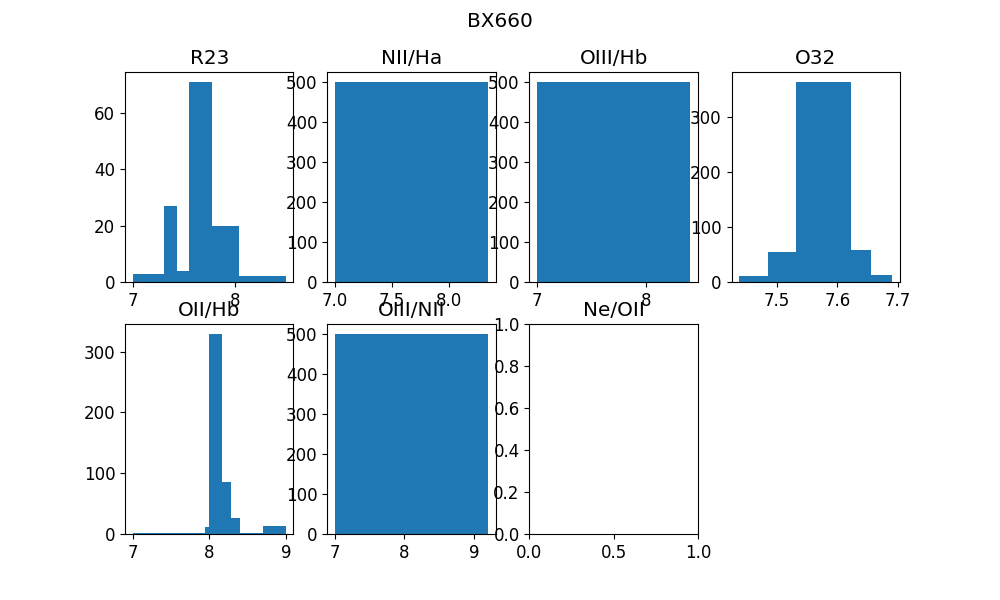

Ne_OII not available


<IPython.core.display.Javascript object>


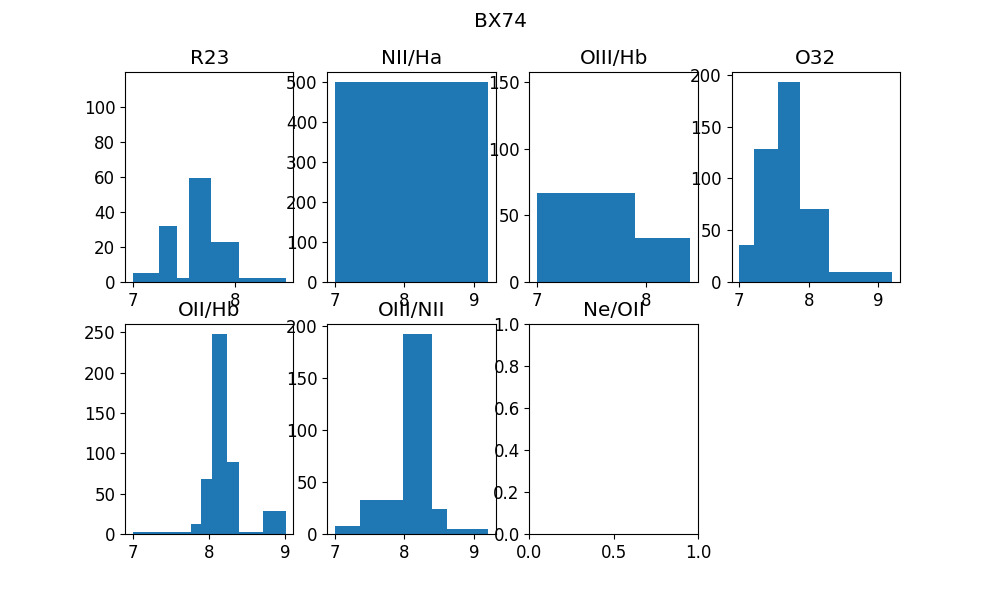

Ne_OII not available


<IPython.core.display.Javascript object>


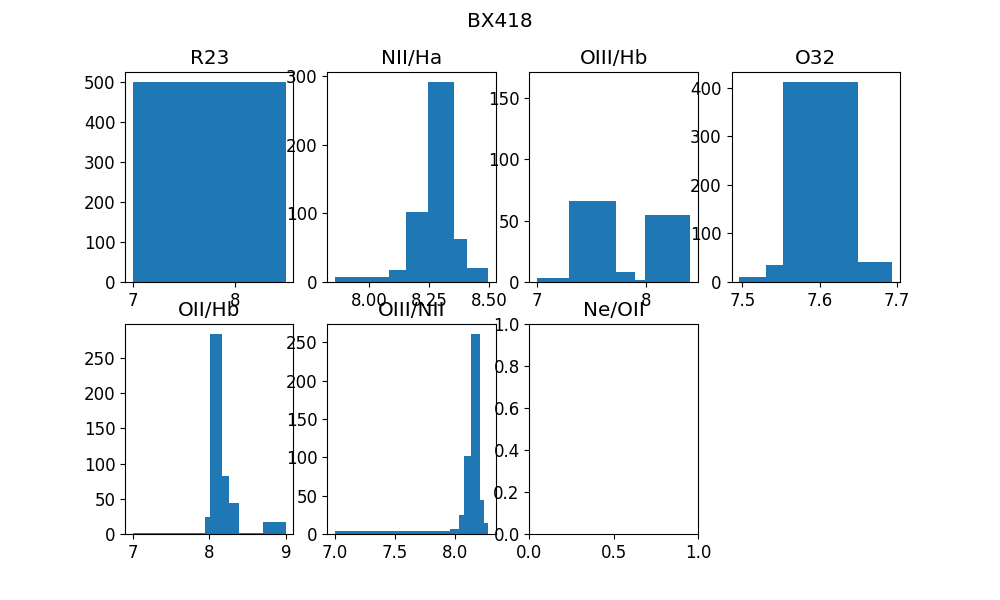

Ne_OII not available


<IPython.core.display.Javascript object>


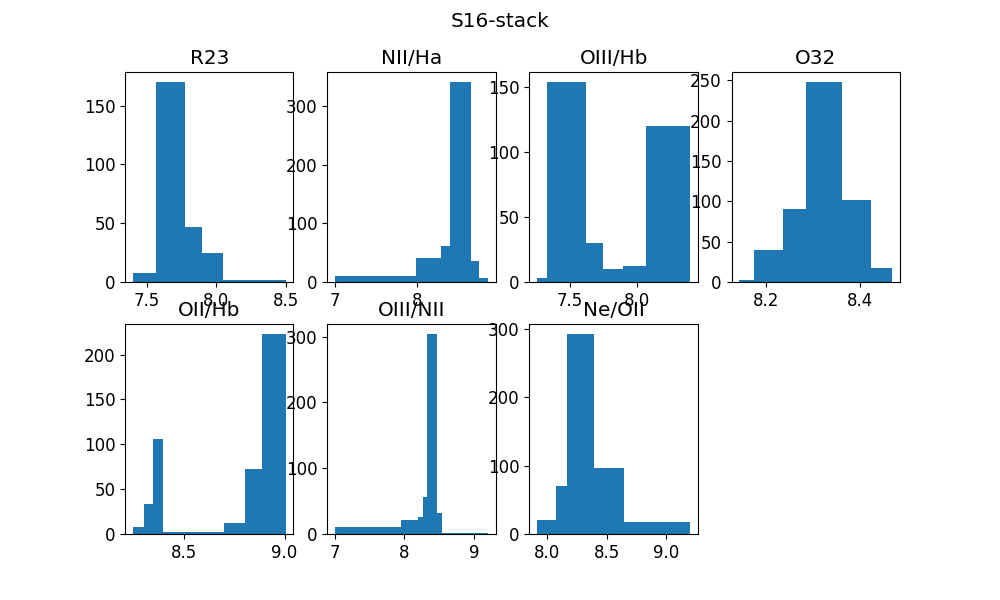

<IPython.core.display.Javascript object>


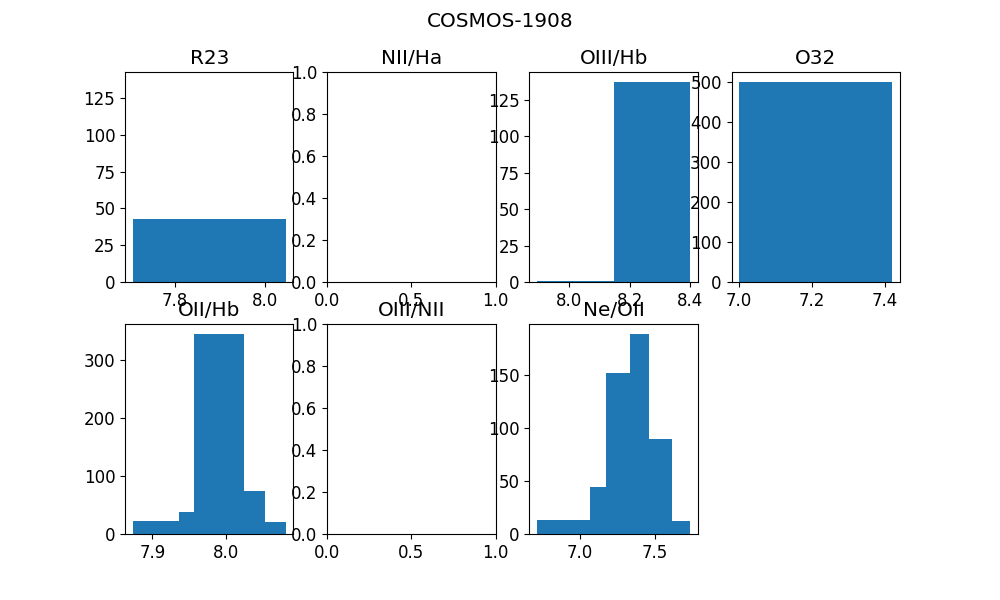

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


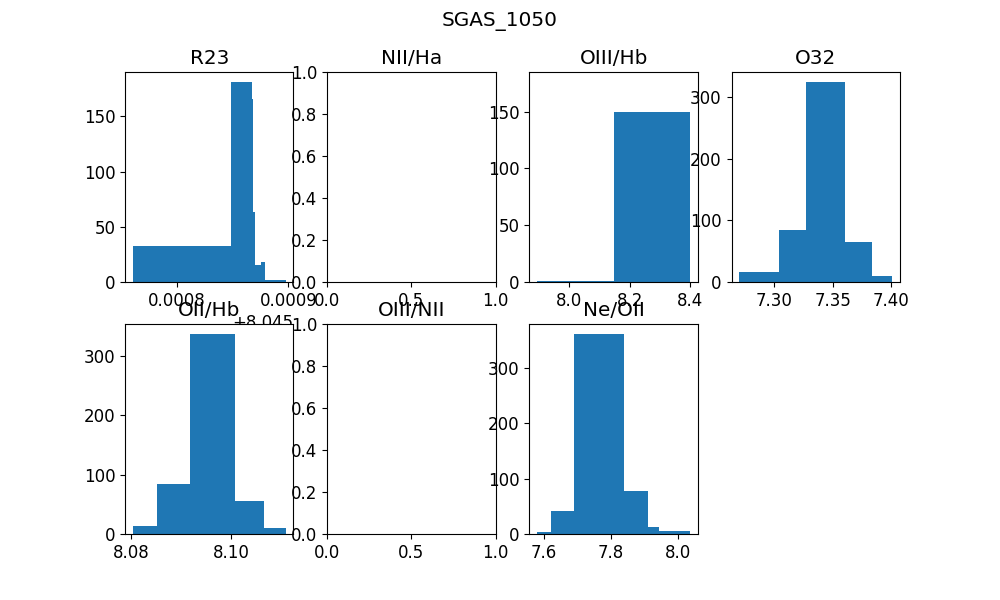

NII_Ha not available
OIII_NII not available


In [6]:
# Data
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')

#Initialise table to save results
maiolino08 = Table(names=['Name','R23','NII_Ha','OIII_Hb','O32','OII_Hb','OIII_NII','Ne_OII',
                                'upR23','upNII_Ha','upOIII_Hb','upO32','upOII_Hb','upOIII_NII','upNe_OII',
                                'lowR23','lowNII_Ha','lowOIII_Hb','lowO32','lowOII_Hb','lowOIII_NII','lowNe_OII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4', 'f4','f4', 'f4','f4','f4','f4', 'f4','f4', 'f4',
                                'f4', 'f4','f4','f4','f4', 'f4','f4',))

for f_init in dered_fluxes:
    
    R23_sample = []
    NII_Ha_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    OIII_NII_sample =[]
    Ne_OII_sample = []

    for i in range(MC_steps):
        
        init_met = np.random.uniform(low=7.0,high=9.0)
        f = perturbed_lines(f_init)        

        params = Parameters()
        params.add('met', value=8.0, min=7.00, max=8.00+0.5) # low metallicity solution 8.00 + delta met of 0.5
        #params.add('met', value=8.0, min=8.00-0.5, max=9.2) # high metallicity solution

        ## R23
        R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
        if np.isfinite(R):
            fit = minimize(minimise_func, params,args=(R,R23_Maiolino2008))
            R23_sample.append(fit.params['met'].value)

        ## NII/Ha
        R = f['NII6584']/f['Ha']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.00, max=9.2)
            fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Maiolino2008))
            NII_Ha_sample.append(fit.params['met'].value)
        else:
            NII_Ha_sample.append(np.nan)         

        ## OIII/Hb
        R = f['OIII5007']/f['Hb']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.00, max=7.9+0.5) # low metallicity solution
            #params['met'].set(value=8.0, min=7.9-0.5, max=9.2) # high metallicity solution
            fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Maiolino2008))
            OIII_Hb_sample.append(fit.params['met'].value)            

        ## O32
        R = f['OIII5007']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.00, max=9.2)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Maiolino2008))
            O32_sample.append(fit.params['met'].value)
  
        ## OII/Hb
        R = f['OIITot']/f['Hb']
        if np.isfinite(R):
            params['met'].set(value=8.0, min=7.00, max=8.7+0.5) # low metallicity solution
            #params['met'].set(value=8.0, min=8.7-0.5, max=9.2) # high metallicity solution
            fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Maiolino2008))
            OII_Hb_sample.append(fit.params['met'].value)

        ## OIII/NII
        R = f['OIII5007']/f['NII6584']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.00, max=9.2)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Maiolino2008))
            OIII_NII_sample.append(fit.params['met'].value)

        ## Ne/OII
        R = f['NeIII3869']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=6.00, max=9.2)
            fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Maiolino2008))
            Ne_OII_sample.append(fit.params['met'].value)
            
                        
    # Some plots
    fig, ax = plt.subplots(2,4,figsize=(10,6))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    try: 
        hist(R23_sample,      bins='blocks',ax=ax[0]) 
    except (ValueError,IndexError):
        print('R23 not available')
    try:
        hist(NII_Ha_sample,   bins='blocks',ax=ax[1])
    except (ValueError,IndexError):
        print('NII_Ha not available')   
    try:
        hist(OIII_Hb_sample,  bins='blocks',ax=ax[2]) 
    except (ValueError,IndexError):
        print('OIII_Hb not available')   
    try:
        hist(O32_sample,      bins='blocks',ax=ax[3]) 
    except (ValueError,IndexError):
        print('O32_sample not available') 
    try:
        hist(OII_Hb_sample,   bins='blocks',ax=ax[4]) 
    except (ValueError,IndexError):
        print('OII_Hb not available') 
    try:
        hist(OIII_NII_sample, bins='blocks',ax=ax[5]) 
    except (ValueError,IndexError):
        print('OIII_NII not available') 
    try:
        hist(Ne_OII_sample,   bins='blocks',ax=ax[6]) 
    except (ValueError,IndexError):
        print('Ne_OII not available') 
        
    ax[0].set_title('R23')
    ax[1].set_title('NII/Ha')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('OII/Hb')
    ax[5].set_title('OIII/NII')
    ax[6].set_title('Ne/OII')
    ax[7].axis('off')
    
    # Save to table
    maiolino08.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,84)-np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,84)-np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(Ne_OII_sample,84)-np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(NII_Ha_sample,50)-np.nanpercentile(NII_Ha_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(OIII_NII_sample,50)-np.nanpercentile(OIII_NII_sample,16),
        np.nanpercentile(Ne_OII_sample,50)-np.nanpercentile(Ne_OII_sample,16)))
                    
maiolino08.write('Metallicity_Maiolino08.dat',format='ascii.fixed_width_two_line')

### Chech if the 50th percentille of the MC is close to what we had before from the direct fit

<IPython.core.display.Javascript object>


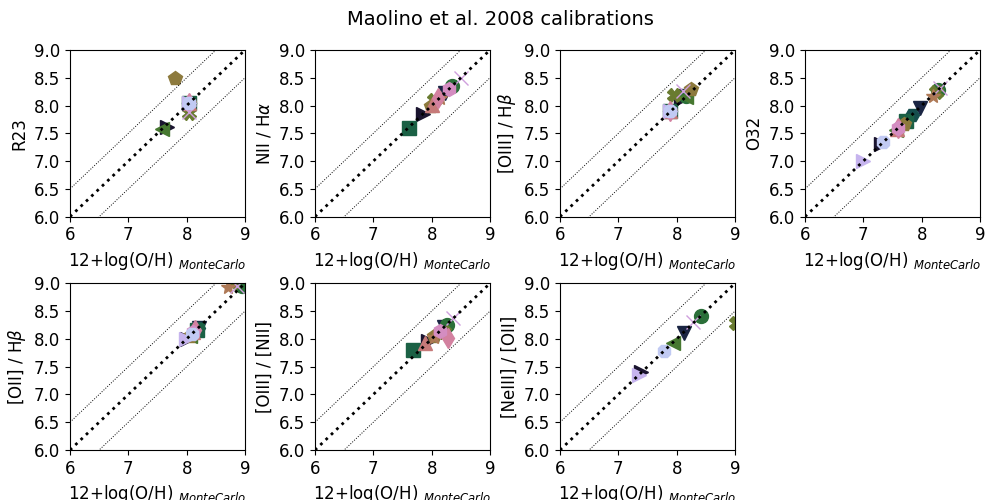

(-0.055000000000000007,
 0.055000000000000007,
 -0.055000000000000007,
 0.055000000000000007)

In [7]:
Met = Table.read('Metallicity_Maiolino08.dat',format='ascii.fixed_width_two_line')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Save values to calculate stats
R23  = []
R23_pred = []

# Fig
fig, ax = plt.subplots(2,4,figsize=(10,5))
fig.suptitle('Maolino et al. 2008 calibrations',fontsize=14)
ax = ax.ravel()
fig.subplots_adjust(top=0.90,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))
plt.rcParams.update({'font.size': 10})

for i,gal in enumerate(Met):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    
    ax[0].plot(gal['R23'],R23_Maiolino08[i],     marker=m,color=c,markersize=10)
    ax[1].plot(gal['NII_Ha'],NII_Ha_Maiolino08[i],  marker=m,color=c,markersize=10)
    ax[2].plot(gal['OIII_Hb'],OIII_Hb_Maiolino08[i], marker=m,color=c,markersize=10)
    ax[3].plot(gal['O32'],O32_Maiolino08[i],     marker=m,color=c,markersize=10)
    ax[4].plot(gal['OII_Hb'],OII_Hb_Maiolino08[i],  marker=m,color=c,markersize=10)
    ax[5].plot(gal['OIII_NII'],OIII_NII_Maiolino08[i],marker=m,color=c,markersize=10)
    ax[6].plot(gal['Ne_OII'],Ne_OII_Maiolino08[i],  marker=m,color=c,markersize=10)
 
    # just for labels
    ax[7].plot(np.nan,np.nan,label=gal['Name'],marker=m,color=c,markersize=7,linewidth=0.)

# set limits and 1:1 ralation
for x in ax[0:7]:
    x.plot(np.arange(6.0,9.5),np.arange(6.0,9.5),color='k',linewidth=2.0,linestyle=':')
    x.plot(np.arange(6.0,9.5),np.arange(6.0,9.5)+0.5,color='k',linewidth=0.7,linestyle=':')
    x.plot(np.arange(6.0,9.5),np.arange(6.0,9.5)-0.5,color='k',linewidth=0.7,linestyle=':')
    x.set_ylim(6.0,9.0)
    x.set_xlim(6.0,9.0)
    x.set_xlabel('12+log(O/H) $_{Monte Carlo}$')

    
# Set titles
ax[0].set_ylabel('R23')
ax[1].set_ylabel('NII / H$\\alpha$')
ax[2].set_ylabel('[OIII] / H$\\beta$')
ax[3].set_ylabel('O32')
ax[4].set_ylabel('[OII] / H$\\beta$')
ax[5].set_ylabel('[OIII] / [NII]')
ax[6].set_ylabel('[NeIII] / [OII]')



ax[7].axis('off')
#ax[7].legend(loc=1,fontsize=8)

## Finally: Maiolino vs Direct met

<IPython.core.display.Javascript object>


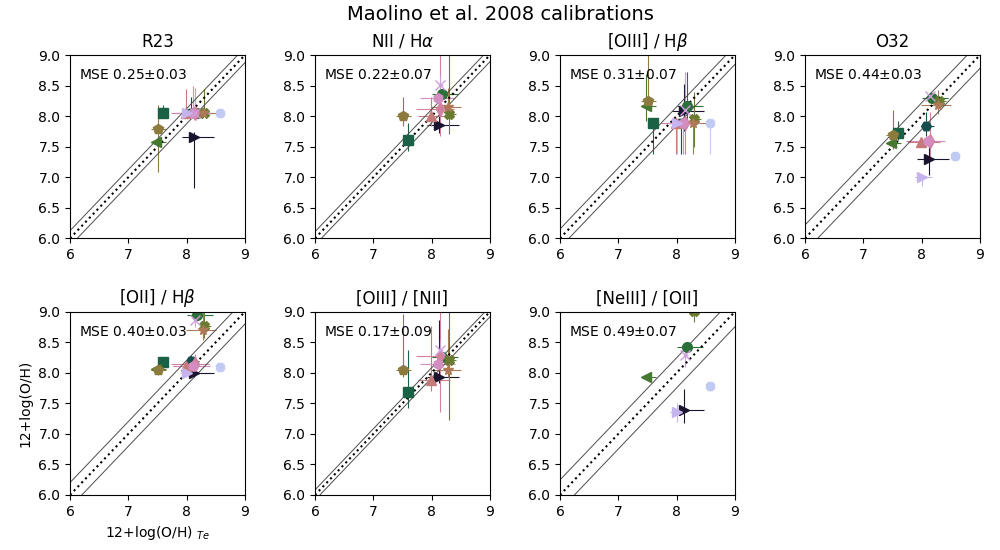

In [8]:
## V1: Compare with direct method and calculate spread
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
direct_Te.remove_row(1)
direct_Te.add_index('Name')
maiolino08 = Table.read('Metallicity_Maiolino08.dat',format='ascii.fixed_width_two_line')
maiolino08.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Save values to calculate stats
y = [] # obtainted metalliciity
w = [] # weights (uncertainties)
x = [] # predicted metallicity (Te)

# Fig
fig, ax = plt.subplots(2,4,figsize=(10,5.5))
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Maolino et al. 2008 calibrations',fontsize=14,y=0.99)

ax = ax.ravel()
fig.subplots_adjust(top=0.90,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    
    met = maiolino08.loc[gal['Name']]
    
    ax[0].errorbar(gal['met'],met['R23'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upR23'],met['lowR23'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[1].errorbar(gal['met'],met['NII_Ha'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNII_Ha'],met['lowNII_Ha'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[2].errorbar(gal['met'],met['OIII_Hb'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb'],met['lowOIII_Hb'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[3].errorbar(gal['met'],met['O32'],  
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upO32'],met['lowO32'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)     
    ax[4].errorbar(gal['met'],met['OII_Hb'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOII_Hb'],met['lowOII_Hb'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[5].errorbar(gal['met'],met['OIII_NII'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_NII'],met['lowOIII_NII'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[6].errorbar(gal['met'],met['Ne_OII'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNe_OII'],met['lowNe_OII'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
         
    # Save results  
    x.append((gal['met'],gal['met'],gal['met'],gal['met'],gal['met'],gal['met'],gal['met'])) # could be prettier
    y.append((met['R23'],met['NII_Ha'],met['OIII_Hb'],met['O32'],met['OII_Hb'],met['OIII_NII'], met['Ne_OII']))
    w.append((met['upR23']+met['lowR23']+gal['lowmet']+gal['upmet'],
              met['upNII_Ha']+met['lowNII_Ha']+gal['lowmet']+gal['upmet'],
              met['upOIII_Hb']+met['lowOIII_Hb']+gal['lowmet']+gal['upmet'],
              met['upO32']+met['lowO32']+gal['lowmet']+gal['upmet'],
              met['upOII_Hb']+met['lowOII_Hb']+gal['lowmet']+gal['upmet'],
              met['upOIII_NII']+met['lowOIII_NII']+gal['lowmet']+gal['upmet'], 
              met['upNe_OII']+met['lowNe_OII']+gal['lowmet']+gal['upmet']))
 

# fix data format
y = np.array(y).T
w = np.array(w).T
x = np.array(x).T
d = []
e = []

# set limits, 1:1 relation and stats
for i in range(7):
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5),color='k',linewidth=1.5,linestyle=':')
    ax[i].set_ylim(6.0,9.0)
    ax[i].set_xlim(6.0,9.0)

    # Stats
    wght = np.array(w[i][~np.isnan(y[i])])
    data = np.array(y[i][~np.isnan(y[i])])
    pred = np.array(x[i][~np.isnan(y[i])])
    mae, emae = mean_absolute_error(pred,data,sample_weight=1./wght),1./np.sum(1./wght)
    rms, erms = np.sqrt(mean_squared_error(pred,data,sample_weight=1./wght)),1./np.sum(1./wght) # uncertainty TBC
    #ax[i].annotate('$\\bar{x}$: %0.2f\n$\sigma$: %0.2f'%(np.nanmean(data-pred),np.nanstd(data-pred)),xy=(10,-1.8))
    ax[i].annotate('MSE %0.2f$\pm$%0.2f'%(mae, emae),xy=(6.15,8.6))
    #ax[i].annotate('RMSE %0.2f'%(rms),xy=(6.7,6.4))
    #ax[i].annotate('MSE %0.2f$\pm$%0.2f'%(mae, emae),xy=(6.7,6.1))

    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5)+mae/2.,color='0.3',linewidth=0.7,linestyle='-')
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5)-mae/2.,color='0.3',linewidth=0.7,linestyle='-')

    # To save in table
    d.append(mae)
    e.append(emae)
    
# Set titles
ax[0].set_title('R23')
ax[1].set_title('NII / H$\\alpha$')
ax[2].set_title('[OIII] / H$\\beta$')
ax[3].set_title('O32')
ax[4].set_title('[OII] / H$\\beta$')
ax[5].set_title('[OIII] / [NII]')
ax[6].set_title('[NeIII] / [OII]')
ax[7].axis('off')
ax[4].set_xlabel('12+log(O/H) $_{Te}$')
ax[4].set_ylabel('12+log(O/H)')


maiolino08.add_row({'Name': "MAE",
                    'R23': d[0],'NII_Ha':d[1],'OIII_Hb':d[2],'O32':d[3],'OII_Hb':d[4],'OIII_NII':d[5],'Ne_OII': d[6],
                    'upR23':e[0],'upNII_Ha':e[1],'upOIII_Hb':e[2],'upO32':e[3],'upOII_Hb':e[4],'upOIII_NII':e[5],
                    'upNe_OII':e[6]})

maiolino08.write('Metallicity_Maiolino08.dat',format='ascii.fixed_width_two_line')
fig.savefig('/Users/vera/Desktop/maiolino.pdf')

<IPython.core.display.Javascript object>


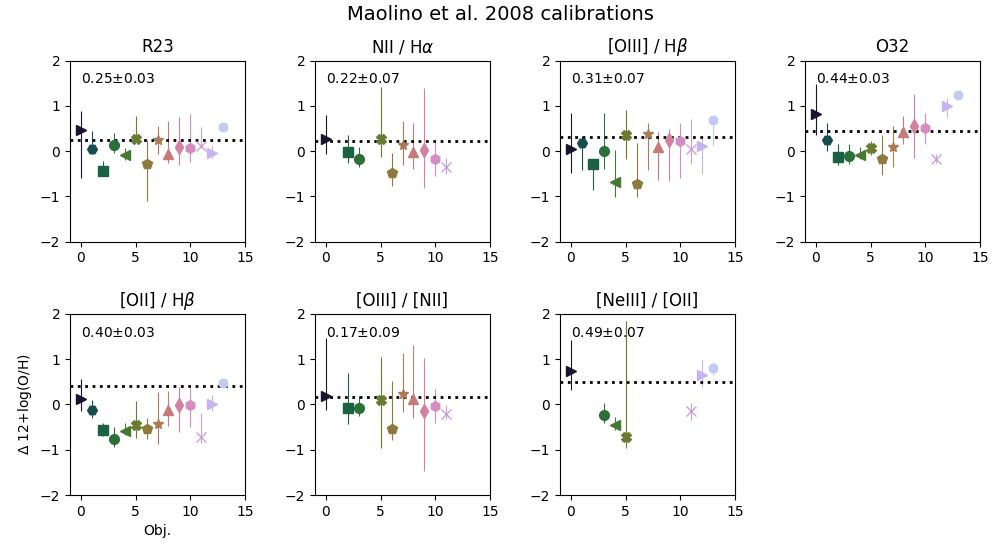

In [9]:
## V2: Compare with direct method and calculate spread
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
direct_Te.remove_row(1)
maiolino08 = Table.read('Metallicity_Maiolino08.dat',format='ascii.fixed_width_two_line')
maiolino08.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Fig
fig, ax = plt.subplots(2,4,figsize=(10,5.5))
fig.suptitle('Maolino et al. 2008 calibrations',fontsize=14,y=0.99)
ax = ax.ravel()
fig.subplots_adjust(top=0.89,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

diff = []
weights = []

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    
    met = maiolino08.loc[gal['Name']]
    
    # Plot
    ax[0].errorbar(i,gal['met']-met['R23'],
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upR23']+gal['lowmet'],met['lowR23']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    
    ax[1].errorbar(i,gal['met']-met['NII_Ha'], 
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNII_Ha']+gal['lowmet'],met['lowNII_Ha']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)

    ax[2].errorbar(i,gal['met']-met['OIII_Hb'], 
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb']+gal['lowmet'],met['lowOIII_Hb']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
        
    ax[3].errorbar(i,gal['met']-met['O32'],  
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upO32']+gal['lowmet'],met['lowO32']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)   

    ax[4].errorbar(i,gal['met']-met['OII_Hb'], 
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOII_Hb']+gal['lowmet'],met['lowOII_Hb']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    
    ax[5].errorbar(i,gal['met']-met['OIII_NII'],
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_NII']+gal['lowmet'],met['lowOIII_NII']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    
    ax[6].errorbar(i,gal['met']-met['Ne_OII'], 
                   #xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNe_OII']+gal['lowmet'],met['lowNe_OII']+gal['upmet'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    
    # Save results
    diff.append((np.abs(gal['met']-met['R23']),
                 np.abs(gal['met']-met['NII_Ha']),
                 np.abs(gal['met']-met['OIII_Hb']),
                 np.abs(gal['met']-met['O32']),
                 np.abs(gal['met']-met['OII_Hb']),
                 np.abs(gal['met']-met['OIII_NII']),
                 np.abs(gal['met']-met['Ne_OII'])))
    
    weights.append((met['upR23']+gal['lowmet']+met['lowR23']+gal['upmet'],
                   met['upNII_Ha']+gal['lowmet']+met['lowNII_Ha']+gal['upmet'],
                   met['upOIII_Hb']+gal['lowmet']+met['lowOIII_Hb']+gal['upmet'],
                   met['upO32']+gal['lowmet']+met['lowO32']+gal['upmet'],
                   met['upOII_Hb']+gal['lowmet']+met['lowOII_Hb']+gal['upmet'],
                   met['upOIII_NII']+gal['lowmet']+met['lowOIII_NII']+gal['upmet'],
                   met['upNe_OII']+gal['lowmet']+met['lowNe_OII']+gal['upmet']))
    
# fix data format
diff = np.array(diff).T
weights = np.array(weights).T

# set mean and dispersion
for i in range(7):
    #ax[i].annotate('$\\bar{x}$: %0.2f\n$\sigma$: %0.2f'%(np.nanmean(diff[i]),np.nanstd(diff[i])),xy=(10,-1.8))
    w = weights[i][~np.isnan(diff[i])]
    data = diff[i][~np.isnan(diff[i])]
    pred = np.zeros_like(data)
    mae , emae = mean_absolute_error(pred,data,sample_weight=1./w), 1./np.sum(1./w)
    ax[i].annotate('%0.2f$\pm$%0.2f'%(mae , emae),xy=(0,1.5))
    ax[i].axhline(mae,color='k',linewidth=2.0,linestyle=':')
    ax[i].set_ylim(-2,2)
    ax[i].set_xlim(-1,15)
    
ax[4].set_xlabel('Obj.')
ax[4].set_ylabel('$\Delta$ 12+log(O/H)')

    
# Set titles
ax[0].set_title('R23')
ax[1].set_title('NII / H$\\alpha$')
ax[2].set_title('[OIII] / H$\\beta$')
ax[3].set_title('O32')
ax[4].set_title('[OII] / H$\\beta$')
ax[5].set_title('[OIII] / [NII]')
ax[6].set_title('[NeIII] / [OII]')
ax[7].axis('off')

plt.savefig('/Users/vera/Desktop/maiolino2.pdf')

## Curti 2017

https://arxiv.org/pdf/1610.06939.pdf

Available diagnostics
- R2 = [O II] λ3727/Hβ
- R3 = [O III] λ5007/Hβ
- O32 = [O III] λ5007/[O II] λ3727
- R23 = ([O III] λ4959,5007 + [O II] λ3727)/Hβ
- N2 = [N II] λ6583/Hα
- O3N2 = R3/N2

In [70]:
## Curti 2016 calibrations. Ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def OII_3727_Hb_Curti17(met):
    """ From Curti+16. Range 7.6 < 12+log(O/H) < 8.3. Error 0.26.
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O II] λ3727 / H beta
    """
    c0,c1,c2,c3 =  0.418, -0.961, -3.505, -1.949
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def OIII_5007_Hb_Curti17(met):
    """ From Curti+16. Range 8.3 < 12+log(O/H) < 8.85. Error 0.07
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O III] λ5007 / Hbeta
    """
    c0,c1,c2,c3 = -0.277, -3.549, -3.593, -0.981        
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def R23_Curti17(met):
    """ From Curti+16. Range  8.4 < 12+log(O/H) < 8.85. Error 0.12
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        ([O III] λ4959,5007 + [O II] λ3727)/Hβ
    """
    c0,c1,c2,c3 = 0.527, -1.569, -1.652, -0.421        
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def NII_6584_Ha_Curti17(met):
    """ From Curti+16
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [N II] λ6583/Hα
    """
    c0,c1,c2,c3,c4  = -0.489, 1.513, -2.554, -5.293, -2.867     
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))


def OIII_5007_OII_3727_Curti17(met):
    """ From Curti+16. Range 7.6 < 12+log(O/H) < 8.85. Error 0.10
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O III] λ5007/[O II] λ3727
    """
    c0,c1,c2 = -0.691, -2.944, -1.308       
    return (10**polyval(met-8.69,(c0,c1,c2)))

def OIII_5007_NII_6584_Curti17(met):
    """ From Curti+16. Range 7.6 < 12+log(O/H) < 8.85. Error 0.09
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        R3/N2
    """
    c0,c1,c2 = 0.281, -4.765, -2.268       
    return (10**polyval(met-8.69,(c0,c1,c2)))

In [71]:
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')

OII_Hb_Curti =[]
OIII_Hb_Curti = []
R23_Curti = []
O32_Curti = []
NII_Ha_Curti = []
OIII_NII_Curti =[]

for f in dered_fluxes:
    
    print('*******************',f['Name'],'*******************')
    params = Parameters()
    params.add('met', value=8.0, min=7.6, max=8.3) 
    params.pretty_print()

    
    ## R2
    R = f['OIITot']/f['Hb']
    if np.isfinite(R):
        fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Curti17))
        OII_Hb_Curti.append(fit.params['met'].value)
        print('R2 metallicity %0.2f'%fit.params['met'].value)
    else:
        OII_Hb_Curti.append(np.nan)
        print('No R2 metallicity')
        
                       
    ## R3
    R = f['OIII5007']/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=8.30, max=8.85)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Curti17))
        OIII_Hb_Curti.append(fit.params['met'].value)
        print('R3 metallicity %0.2f'%fit.params['met'].value)
    else:
        OIII_Hb_Curti.append(np.nan)
        print('No R3 metallicity')                
    
             
    ## R23
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=8.4, max=8.85)
        fit = minimize(minimise_func, params,args=(R,R23_Curti17))
        R23_Curti.append(fit.params['met'].value)
        print('R23 metallicity %0.2f'%fit.params['met'].value)
    else:
        R23_Curti.append(np.nan)
        print('No R23 metallicity')                
    
    
    ## O32
    R = f['OIII5007']/f['OIITot']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=8.85)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Curti17))
        O32_Curti.append(fit.params['met'].value)
        print('O32 metallicity %0.2f'%fit.params['met'].value)
    else:
        O32_Curti.append(np.nan)
        print('No O32 metallicity')
     
        
    ## N2
    R = f['NII6584']/f['Ha']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=8.85)
        fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Curti17))
        NII_Ha_Curti.append(fit.params['met'].value)
        print('N2 metallicity %0.2f'%fit.params['met'].value)
    else:
        NII_Ha_Curti.append(np.nan)
        print('No OII/Hb metallicity')
               
                       
    ## O3N2 = R3/N2
    R = (f['OIII5007']/f['Ha'])/(f['NII6584']/f['Ha'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=8.85)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Curti17))
        OIII_NII_Curti.append(fit.params['met'].value)
        print('O3N2 metallicity %0.2f'%fit.params['met'].value)
    else:
        OIII_NII_Curti.append(np.nan)
        print('No O3N2 metallicity')


('*******************', 'CSWA20', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8      7.6      8.3     None     True     None     None
R2 metallicity 7.65
R3 metallicity 8.30
R23 metallicity 8.40
O32 metallicity 7.60
N2 metallicity 7.93
O3N2 metallicity 8.26
('*******************', 'USD-12539', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8      7.6      8.3     None     True     None     None
R2 metallicity 8.05
R3 metallicity 8.30
No R23 metallicity
O32 metallicity 8.12
N2 metallicity 8.22
O3N2 metallicity 8.39
('*******************', 'Abell_860_359', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8      7.6      8.3     None     True     None     None
R2 metallicity 8.05
R3 metallicity 8.30
R23 metallicity 8.40
O32 metallicity 8.03
No OII/Hb metallicity
No O3N2 metallicity
('*******************', 'Abell_2

### Get Error bars

<IPython.core.display.Javascript object>


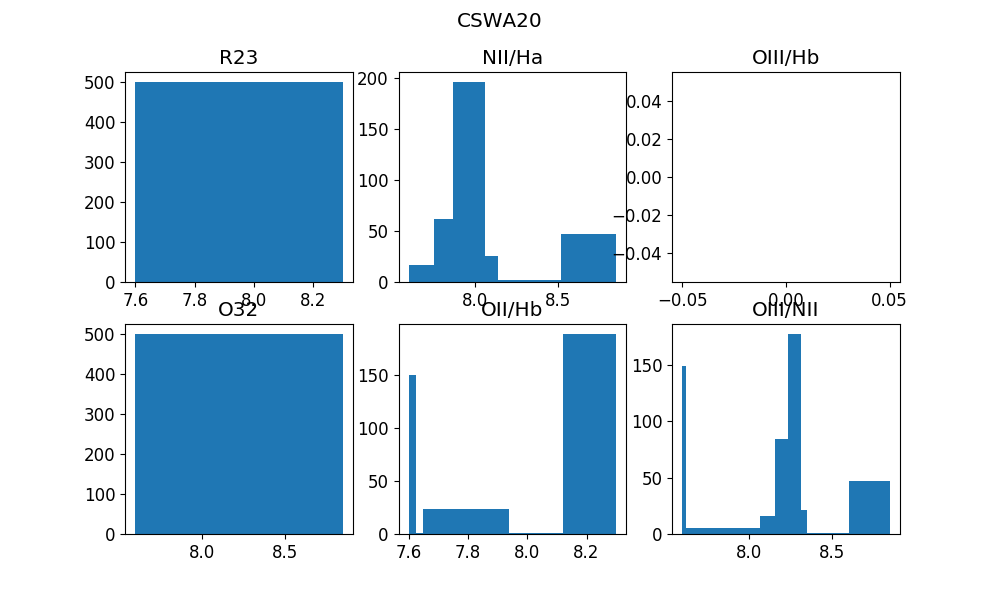

<IPython.core.display.Javascript object>


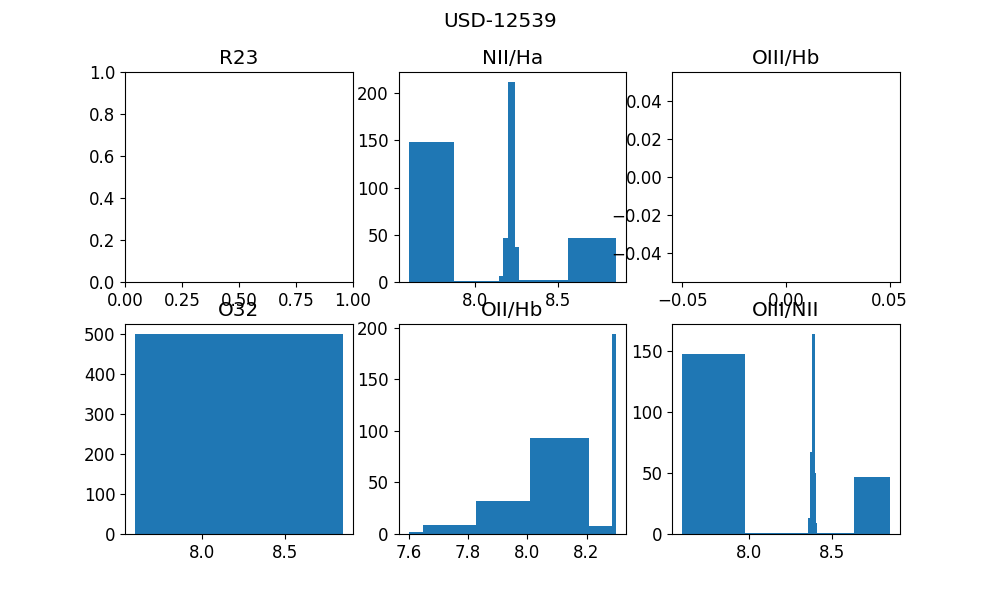

R23 not available


<IPython.core.display.Javascript object>


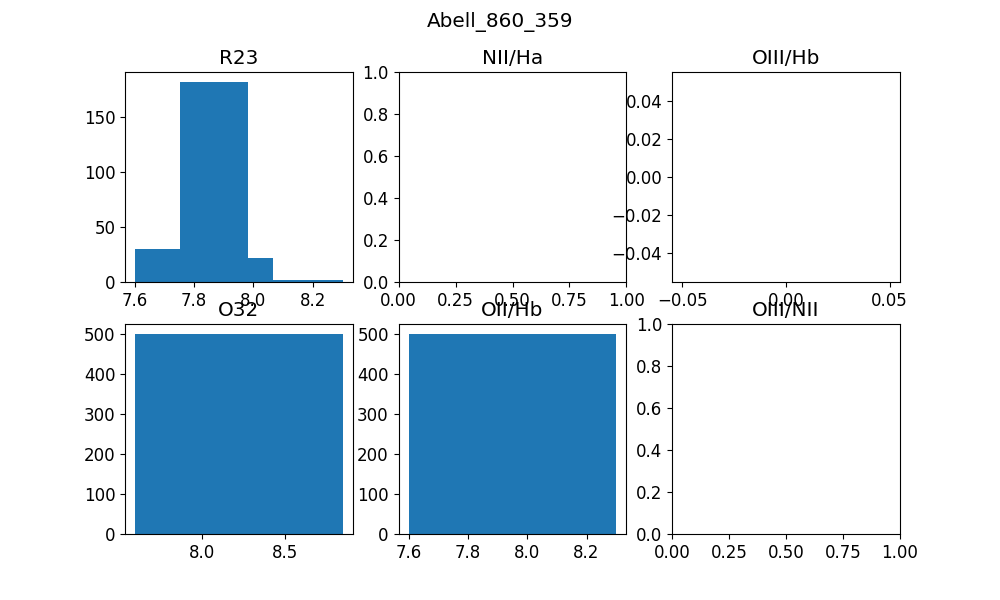

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


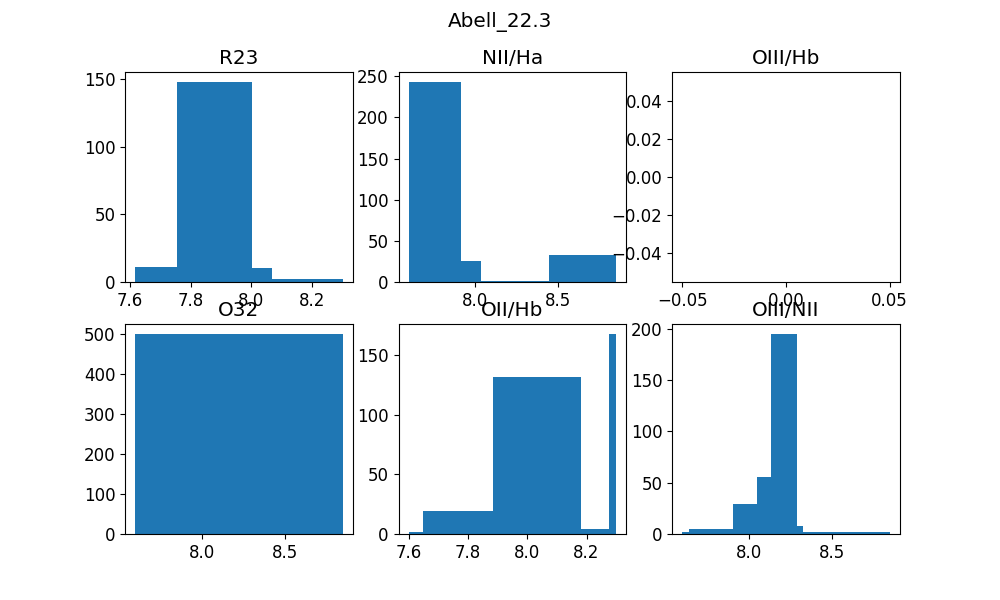

<IPython.core.display.Javascript object>


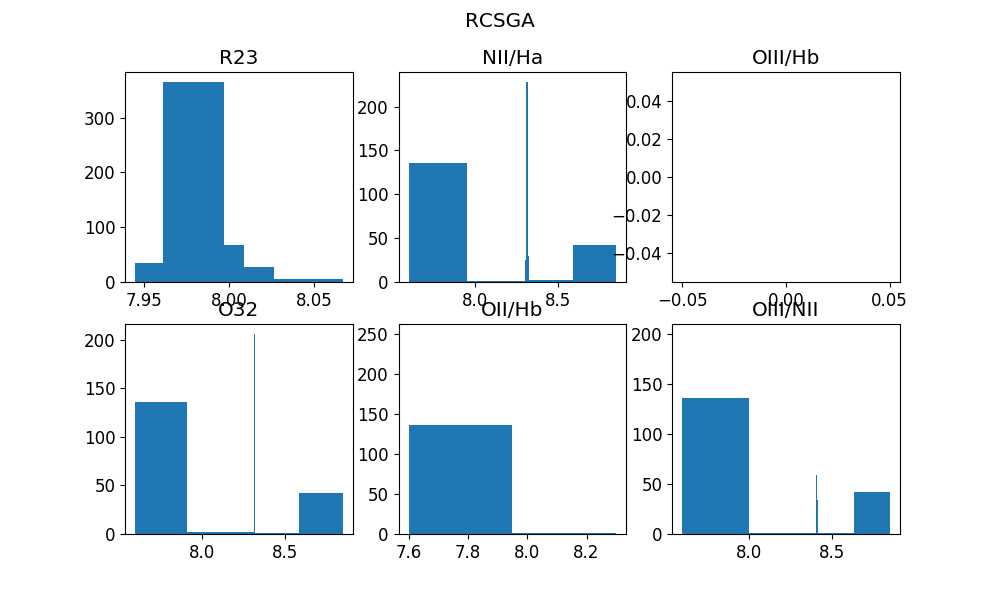

<IPython.core.display.Javascript object>


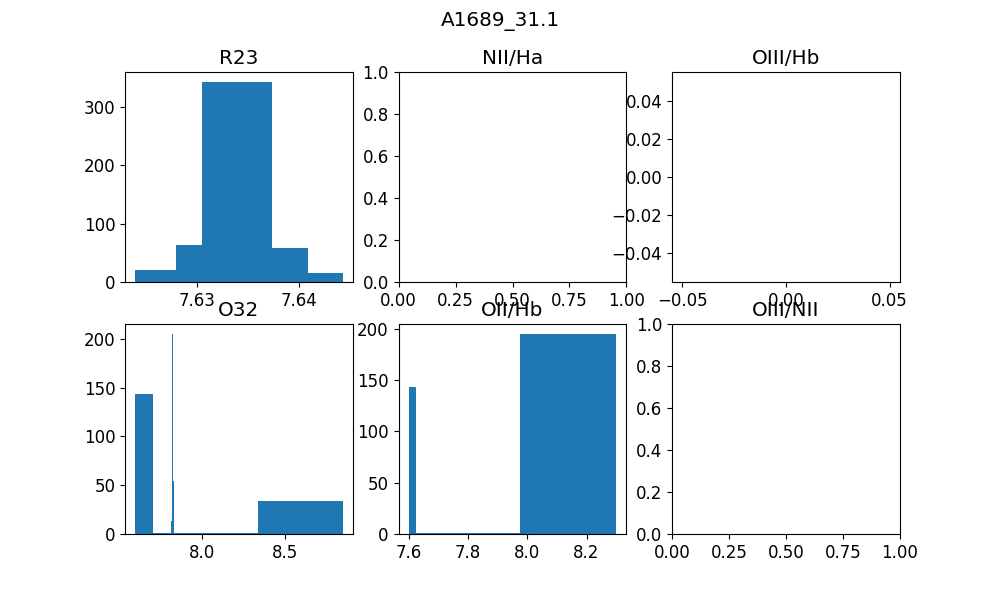

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


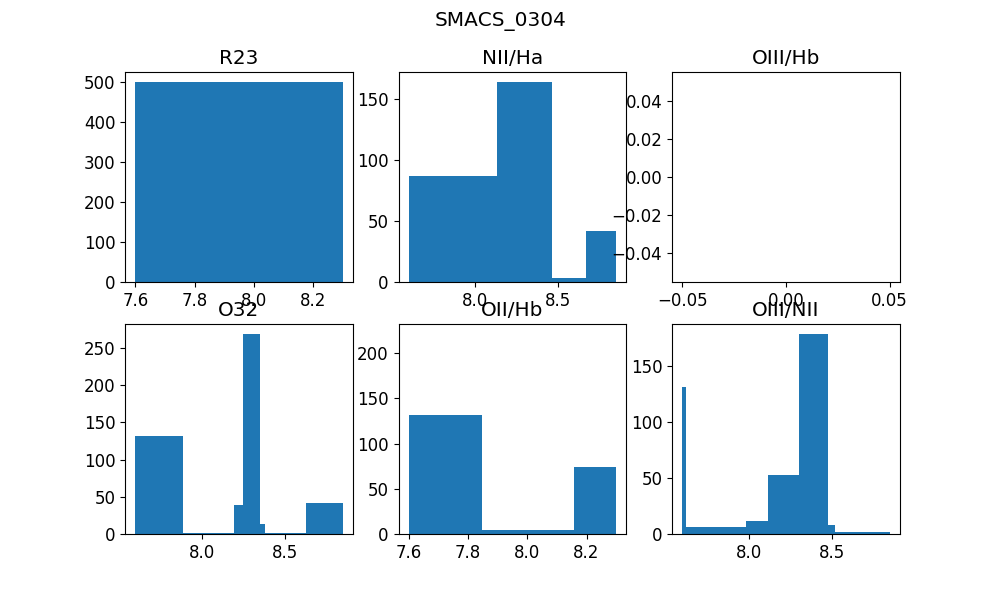

<IPython.core.display.Javascript object>


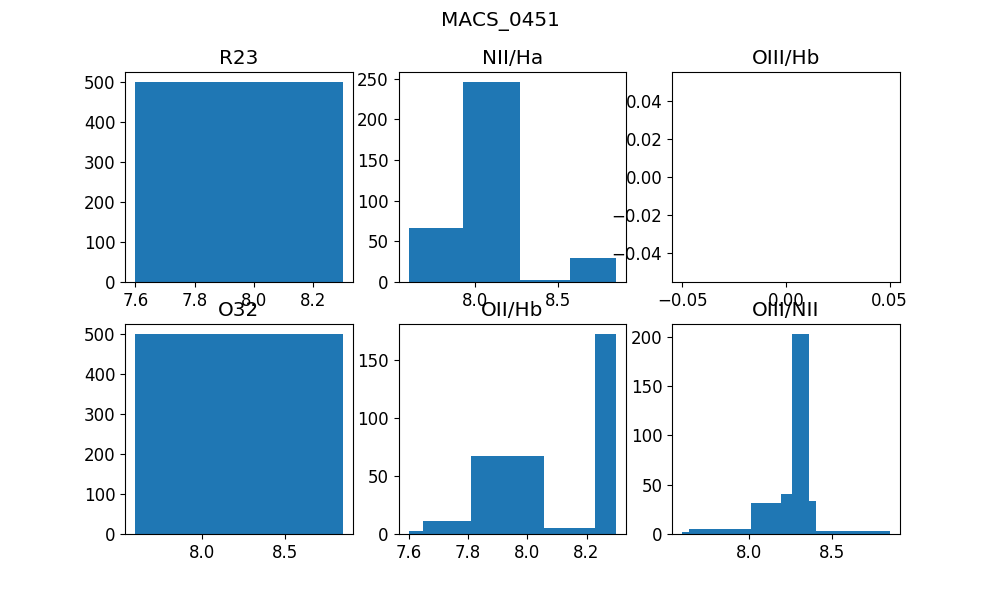

<IPython.core.display.Javascript object>


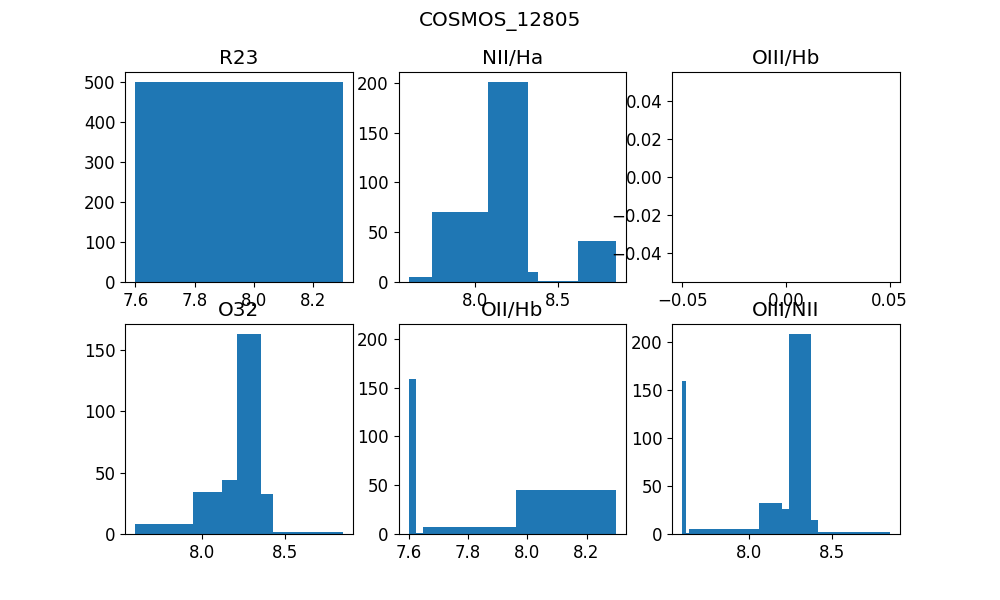

<IPython.core.display.Javascript object>


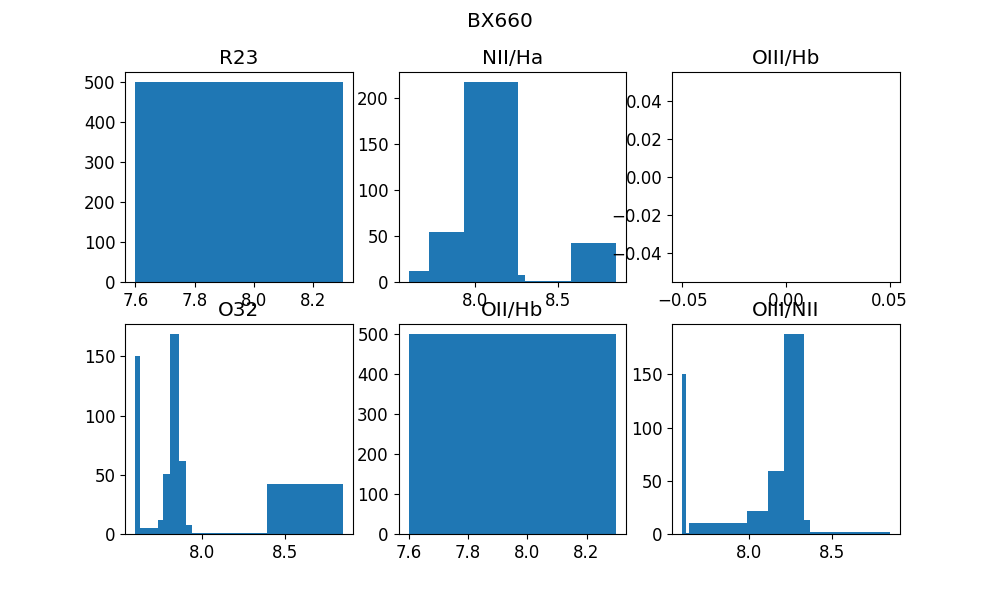

<IPython.core.display.Javascript object>


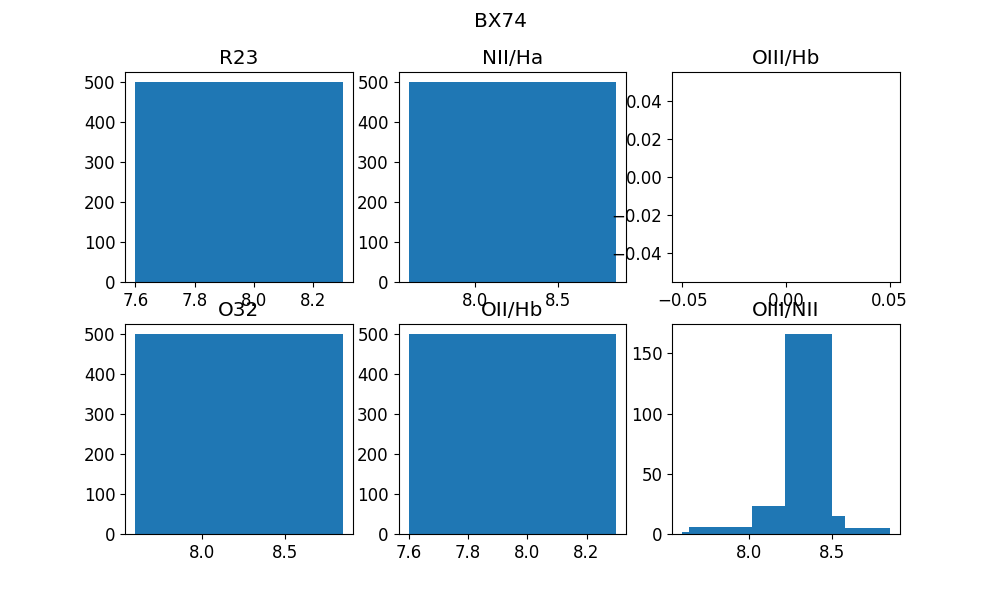

<IPython.core.display.Javascript object>


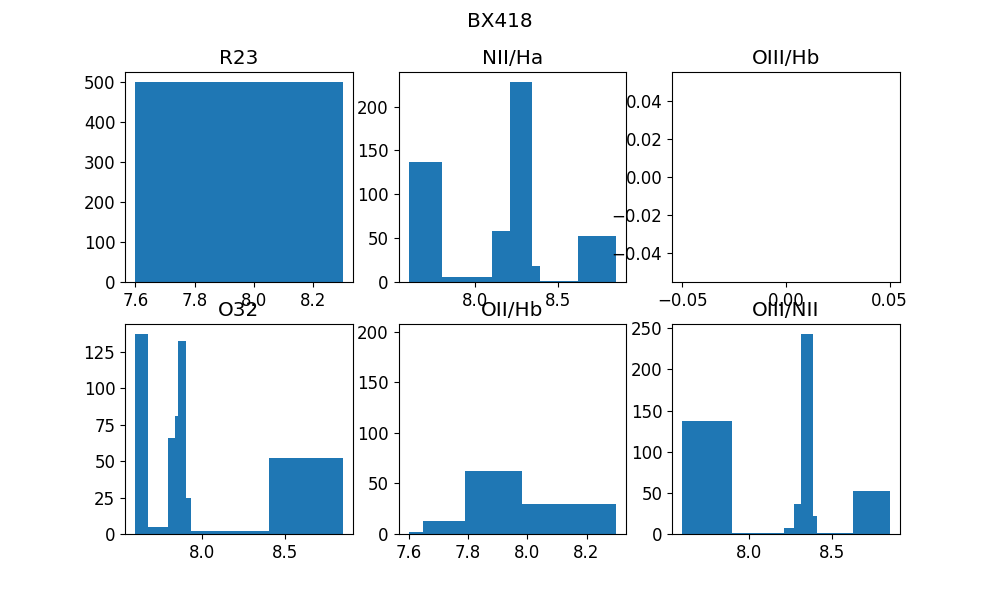

<IPython.core.display.Javascript object>


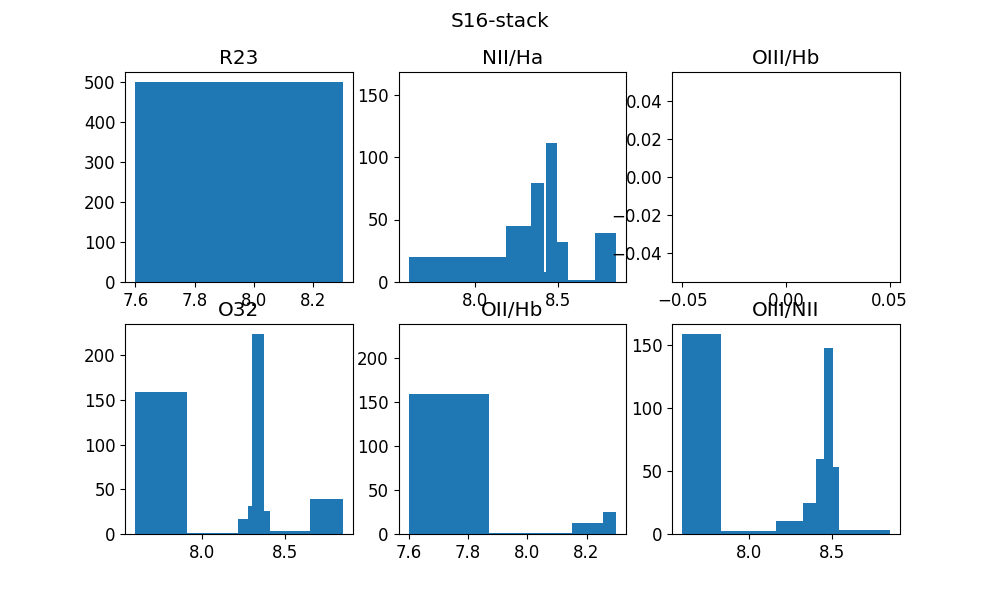

<IPython.core.display.Javascript object>


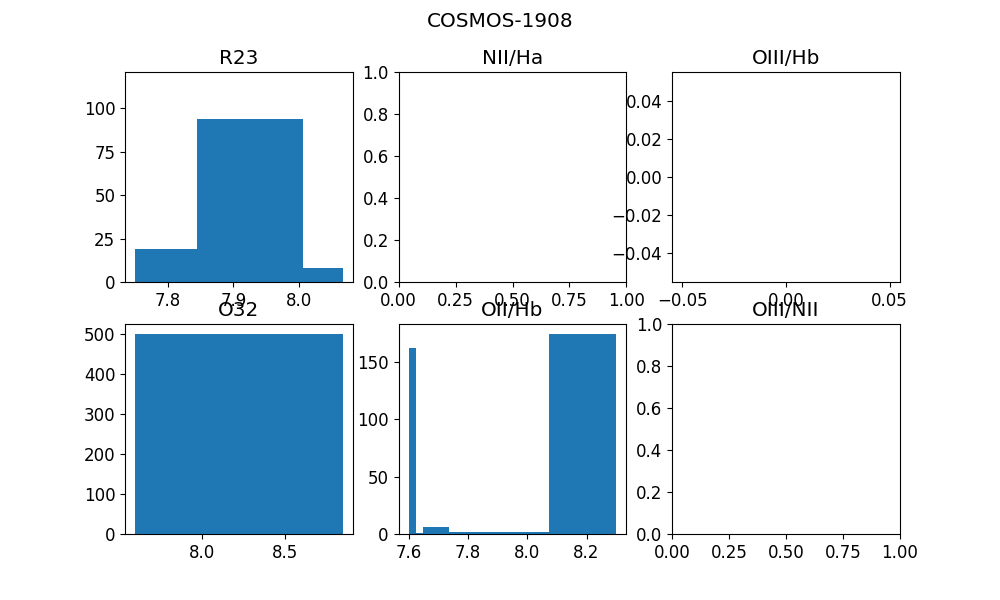

NII_Ha not available
OIII_NII not available


<IPython.core.display.Javascript object>


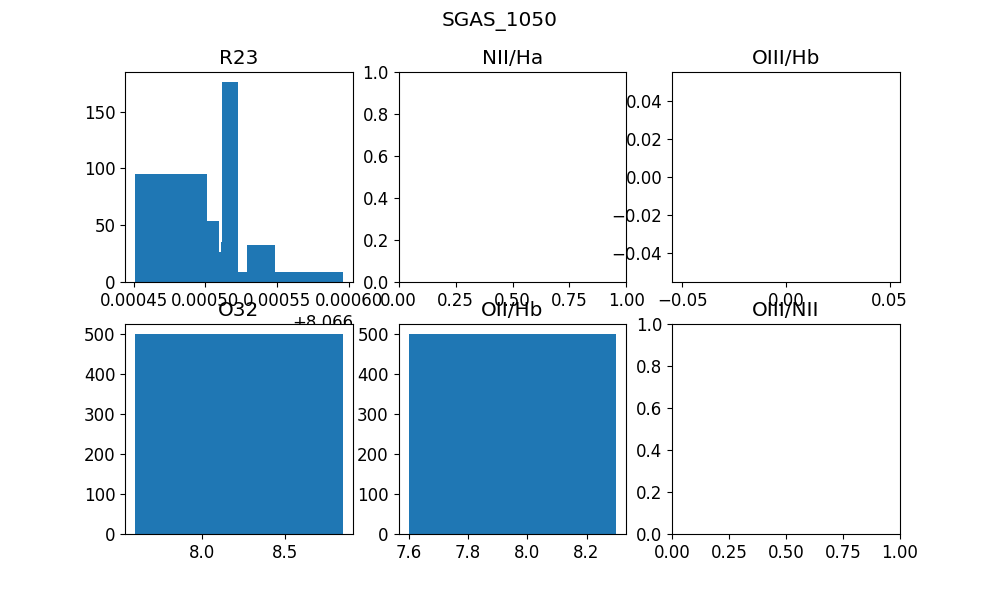

NII_Ha not available
OIII_NII not available


In [72]:
# Data
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')

#Initialise table to save results
curti17 = Table(names=['Name','R23','NII_Ha','OIII_Hb','O32','OII_Hb','OIII_NII',
                                'upR23','upNII_Ha','upOIII_Hb','upO32','upOII_Hb','upOIII_NII',
                                'lowR23','lowNII_Ha','lowOIII_Hb','lowO32','lowOII_Hb','lowOIII_NII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4', 'f4','f4', 'f4','f4','f4','f4', 'f4','f4', 'f4',
                                'f4', 'f4','f4','f4'))

for f_init in dered_fluxes:
    
    R23_sample = []
    NII_Ha_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    OIII_NII_sample =[]

    for i in range(MC_steps):
        
        init_met = np.random.uniform(low=7.0,high=9.0)
        f = perturbed_lines(f_init)        

        params = Parameters()
        params.add('met', value=8.0, min=7.6, max=8.3) 

        ## R23
        R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
        if np.isfinite(R):
            fit = minimize(minimise_func, params,args=(R,R23_Curti17))
            R23_sample.append(fit.params['met'].value)
        else:
            R23_sample.append(np.nan)

        ## NII/Ha
        R = f['NII6584']/f['Ha']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.60, max=8.85)
            fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Curti17))
            NII_Ha_sample.append(fit.params['met'].value)
        else:
            NII_Ha_sample.append(np.nan)         

        ## OIII/Hb
        R = f['OIII5007']/f['Hb']
        if np.isfinite(R):
            params['met'].set(value=8.0, min=8.2, max=8.85) 
            fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Curti17))
            OIII_Hb_sample.append(fit.params['met'].value) 
        else:
            OIII_Hb_sample.append(np.nan)

        ## O32
        R = f['OIII5007']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.60, max=8.85)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Curti17))
            O32_sample.append(fit.params['met'].value)
        else:
            O32_sample.append(np.nan)    
  
        ## OII/Hb
        R = f['OIITot']/f['Hb']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.60, max=8.3) 
            fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Curti17))
            OII_Hb_sample.append(fit.params['met'].value)
        else:
            OII_Hb_sample.append(np.nan)

        ## OIII/NII
        R = f['OIII5007']/f['NII6584']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.6, max=8.85)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Curti17))
            OIII_NII_sample.append(fit.params['met'].value)
        else:
            OIII_NII_sample.append(np.nan)

                        
    # Some plots
    fig, ax = plt.subplots(2,3,figsize=(10,6))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    try: 
        hist(R23_sample,      bins='blocks',ax=ax[0]) 
    except (ValueError,IndexError):
        print('R23 not available')
    try:
        hist(NII_Ha_sample,   bins='blocks',ax=ax[1])
    except (ValueError,IndexError):
        print('NII_Ha not available')   
    try:
        hist(OIII_Hb_sample,  bins='blocks',ax=ax[2]) 
    except (ValueError,IndexError):
        print('OIII_Hb not available')   
    try:
        hist(O32_sample,      bins='blocks',ax=ax[3]) 
    except (ValueError,IndexError):
        print('O32_sample not available') 
    try:
        hist(OII_Hb_sample,   bins='blocks',ax=ax[4]) 
    except (ValueError,IndexError):
        print('OII_Hb not available') 
    try:
        hist(OIII_NII_sample, bins='blocks',ax=ax[5]) 
    except (ValueError,IndexError):
        print('OIII_NII not available') 
        
    ax[0].set_title('R23')
    ax[1].set_title('NII/Ha')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('OII/Hb')
    ax[5].set_title('OIII/NII')
    
    # Save to table
    curti17.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(NII_Ha_sample,84)-np.nanpercentile(NII_Ha_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(OIII_NII_sample,84)-np.nanpercentile(OIII_NII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(NII_Ha_sample,50)-np.nanpercentile(NII_Ha_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(OIII_NII_sample,50)-np.nanpercentile(OIII_NII_sample,16)))
                    
curti17.write('Metallicity_Curti17.dat',format='ascii.fixed_width_two_line')

## Plot

<IPython.core.display.Javascript object>


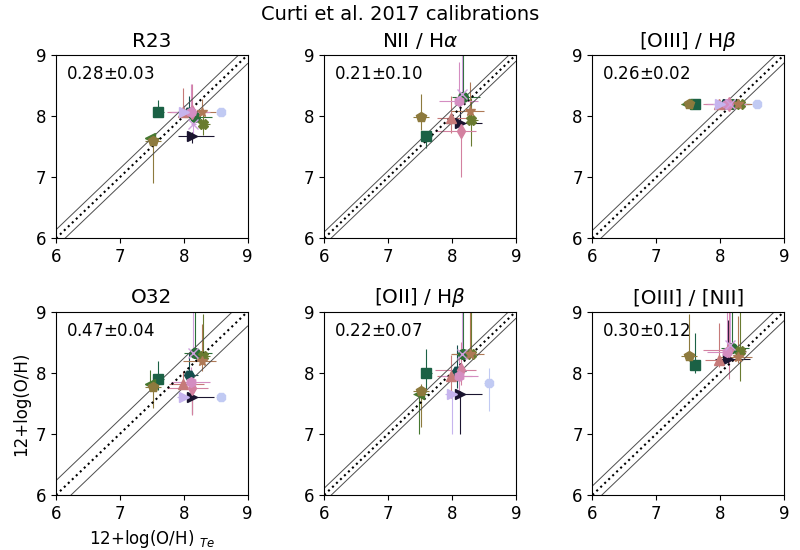

In [73]:
# Compare with the direct method
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
direct_Te.remove_row(1)
direct_Te.add_index('Name')
curti17 = Table.read('Metallicity_Curti17.dat',format='ascii.fixed_width_two_line')
curti17.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Save values to calculate stats
y = [] # obtainted metalliciity
w = [] # weights (uncertainties)
x = [] # predicted metallicity (Te)

# Fig
fig, ax = plt.subplots(2,3,figsize=(8,5.5))
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Curti et al. 2017 calibrations',fontsize=14,y=0.99)

ax = ax.ravel()
fig.subplots_adjust(top=0.90,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    
    met = curti17.loc[gal['Name']]
    
    ax[0].errorbar(gal['met'],met['R23'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upR23'],met['lowR23'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[1].errorbar(gal['met'],met['NII_Ha'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNII_Ha'],met['lowNII_Ha'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[2].errorbar(gal['met'],met['OIII_Hb'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb'],met['lowOIII_Hb'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[3].errorbar(gal['met'],met['O32'],  
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upO32'],met['lowO32'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)     
    ax[4].errorbar(gal['met'],met['OII_Hb'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOII_Hb'],met['lowOII_Hb'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[5].errorbar(gal['met'],met['OIII_NII'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_NII'],met['lowOIII_NII'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
         
    # Save results  
    x.append((gal['met'],gal['met'],gal['met'],gal['met'],gal['met'],gal['met'])) # could be prettier
    y.append((met['R23'],met['NII_Ha'],met['OIII_Hb'],met['O32'],met['OII_Hb'],met['OIII_NII']))
    w.append((met['upR23']+met['lowR23']+gal['lowmet']+gal['upmet'],
              met['upNII_Ha']+met['lowNII_Ha']+gal['lowmet']+gal['upmet'],
              met['upOIII_Hb']+met['lowOIII_Hb']+gal['lowmet']+gal['upmet'],
              met['upO32']+met['lowO32']+gal['lowmet']+gal['upmet'],
              met['upOII_Hb']+met['lowOII_Hb']+gal['lowmet']+gal['upmet'],
              met['upOIII_NII']+met['lowOIII_NII']+gal['lowmet']+gal['upmet']))
 

# fix data format
y = np.array(y).T
w = np.array(w).T
x = np.array(x).T
d = []
e = []

# set limits, 1:1 relation and stats
for i in range(6):
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5),color='k',linewidth=1.5,linestyle=':')
    ax[i].set_ylim(6.0,9.0)
    ax[i].set_xlim(6.0,9.0)

    # Stats
    wght = np.array(w[i][~np.isnan(y[i])])
    data = np.array(y[i][~np.isnan(y[i])])
    pred = np.array(x[i][~np.isnan(y[i])])
    mae, emae = mean_absolute_error(pred,data,sample_weight=1./wght),1./np.sum(1./wght)
    #ax[i].annotate('$\\bar{x}$: %0.2f\n$\sigma$: %0.2f'%(np.nanmean(data-pred),np.nanstd(data-pred)),xy=(10,-1.8))
    ax[i].annotate('%0.2f$\pm$%0.2f'%(mae, emae),xy=(6.15,8.6))
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5)+mae/2.,color='0.3',linewidth=0.7,linestyle='-')
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5)-mae/2.,color='0.3',linewidth=0.7,linestyle='-')
    d.append(mae)
    e.append(emae)

# Set titles
ax[0].set_title('R23')
ax[1].set_title('NII / H$\\alpha$')
ax[2].set_title('[OIII] / H$\\beta$')
ax[3].set_title('O32')
ax[4].set_title('[OII] / H$\\beta$')
ax[5].set_title('[OIII] / [NII]')
ax[3].set_xlabel('12+log(O/H) $_{Te}$')
ax[3].set_ylabel('12+log(O/H)')

#Save to Table 
curti17.add_row({'Name':'MAE',
                 'R23':d[0],'NII_Ha':d[1],'OIII_Hb':d[2],'O32':d[3],'OII_Hb':d[4],'OIII_NII':d[5],
                 'upR23':e[0],'upNII_Ha':e[1],'upOIII_Hb':e[2],'upO32':e[3],'upOII_Hb':e[4],'upOIII_NII':e[5]})

curti17.write('Metallicity_Curti17.dat',format='ascii.fixed_width_two_line')
fig.savefig('/Users/vera/Desktop/curti.pdf')

## Jones 2015

In [3]:
## Jones 2015 calibrations. Ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def NeIII_3870_OII_3727_Jones15(met):
    """ From Jones+15. Error 0.22.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [Ne iii]/[O ii]
    """
    c0,c1 =  16.8974, -2.1588
    return (10**polyval(met,(c0,c1)))

def OIII_5007_OII_3727_Jones15(met):
    """ From Jones+15. Error 0.23.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O iii]/[O ii]
    """
    c0,c1 =  17.9828, -2.1552
    return (10**polyval(met,(c0,c1)))


def NeIII_3870_OIII_5007_Jones15(met):
    """ From Jones+15. Error 0.04.
    This is a VERY BAD diagnostic!
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [Ne iii]/[O iii]
    """
    c0,c1 = -1.0854, -0.0036
    return (10**polyval(met,(c0,c1)))


def OIII_5007_Hb_Jones15(met):
    """ From Jones+15. Error 0.10.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O iii]/H beta
    """
    c0,c1,c2 = -88.4378, 22.7529, -1.4501
    return (10**polyval(met,(c0,c1,c2)))


def OII_3727_Hb_Jones15(met):
    """ From Jones+15. Error 0.15.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O ii] / Hbeta
    """
    c0,c1,c2 = -154.9571, 36.9128, -2.1921
    return (10**polyval(met,(c0,c1,c2)))


def R23_Jones15(met):
    """ From Jones+15. Error 0.06.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
       R23
    """
    c0,c1,c2 = -54.1003, 13.9083, -0.8782
    return (10**polyval(met,(c0,c1,c2)))

In [4]:
## Minimising function
from lmfit import minimize, Parameters

dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')

NeO2_Jones = []
O32_Jones = []
NeO3_Jones = []
O3_Jones = []
O2_Jones = []
R23_Jones = []

for f in dered_fluxes:
    
    print('*******************',f['Name'],'*******************')
    params = Parameters()
    params.add('met', value=8.0, min=7.6, max=9.0) 
    params.pretty_print()

    ## NeOII
    R = f['NeIII3869']/f['OIITot']
    if np.isfinite(R):
        fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Jones15))
        NeO2_Jones.append(fit.params['met'].value)
        print('NeO2 metallicity %0.2f'%fit.params['met'].value)
    else:
        NeO2_Jones.append(np.nan)
        print('No NeO2 metallicity')
 
    ## O32
    R = f['OIII5007']/f['OIITot']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Jones15))
        O32_Jones.append(fit.params['met'].value)
        print('O32 metallicity %0.2f'%fit.params['met'].value)
    else:
        O32_Jones.append(np.nan)
        print('No O32 metallicity')                
    
    ## NeOIII
    R = f['NeIII3869']/f['OIII5007']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,NeIII_3870_OIII_5007_Jones15))
        NeO3_Jones.append(fit.params['met'].value)
        print('NeO3 metallicity %0.2f'%fit.params['met'].value)
    else:
        NeO3_Jones.append(np.nan)
        print('No NeO3 metallicity')  
    
    ## O3
    R = f['OIII5007']/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Jones15))
        O3_Jones.append(fit.params['met'].value)
        print('O3 metallicity %0.2f'%fit.params['met'].value)
    else:
        O3_Jones.append(np.nan)
        print('No O3 metallicity') 
        
    ## O2
    R = f['OIITot']/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Jones15))
        O2_Jones.append(fit.params['met'].value)
        print('O2 metallicity %0.2f'%fit.params['met'].value)
    else:
        O2_Jones.append(np.nan)
        print('No O2 metallicity')  

    ## R23
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=8.5)
        fit = minimize(minimise_func, params,args=(R,R23_Jones15))
        R23_Jones.append(fit.params['met'].value)
        print('R23 metallicity %0.2f'%fit.params['met'].value)
    else:
        R23_Jones.append(np.nan)
        print('No R23 metallicity')                
    

('*******************', 'CSWA20', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8      7.6        9     None     True     None     None
NeO2 metallicity 7.88
O32 metallicity 7.87
NeO3 metallicity 9.00
O3 metallicity 8.13
O2 metallicity 7.83
R23 metallicity 8.28
('*******************', 'USD-12539', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8      7.6        9     None     True     None     None
NeO2 metallicity 8.14
O32 metallicity 8.08
NeO3 metallicity 9.00
O3 metallicity 8.15
O2 metallicity 8.03
No R23 metallicity
('*******************', 'Abell_860_359', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
met         8      7.6        9     None     True     None     None
No NeO2 metallicity
O32 metallicity 8.03
No NeO3 metallicity
O3 metallicity 7.99
O2 metallicity 8.03
R23 metallicity 7.92
('*******************', 'Abell

## Calculate error bars

<IPython.core.display.Javascript object>


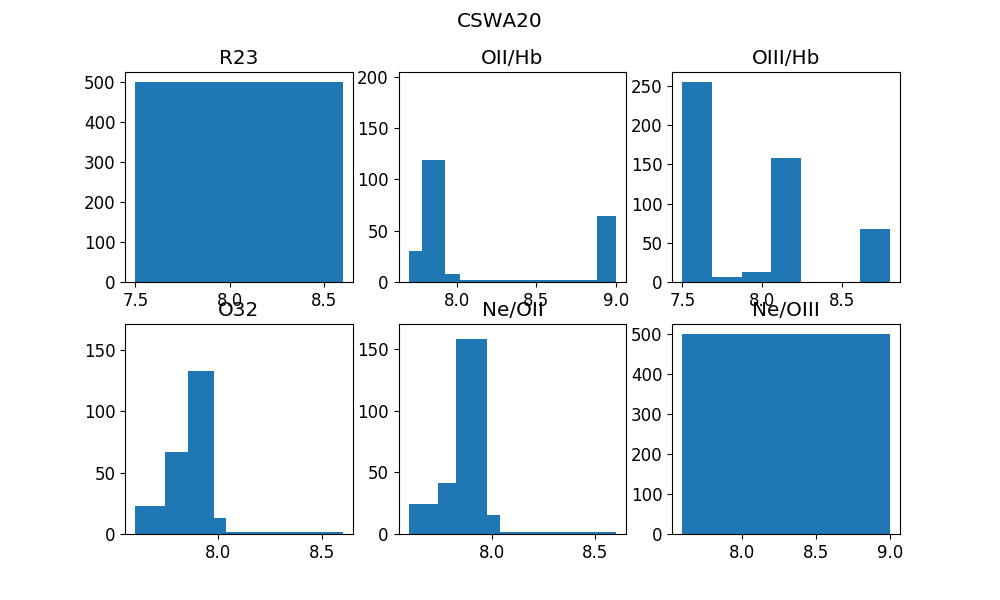

<IPython.core.display.Javascript object>


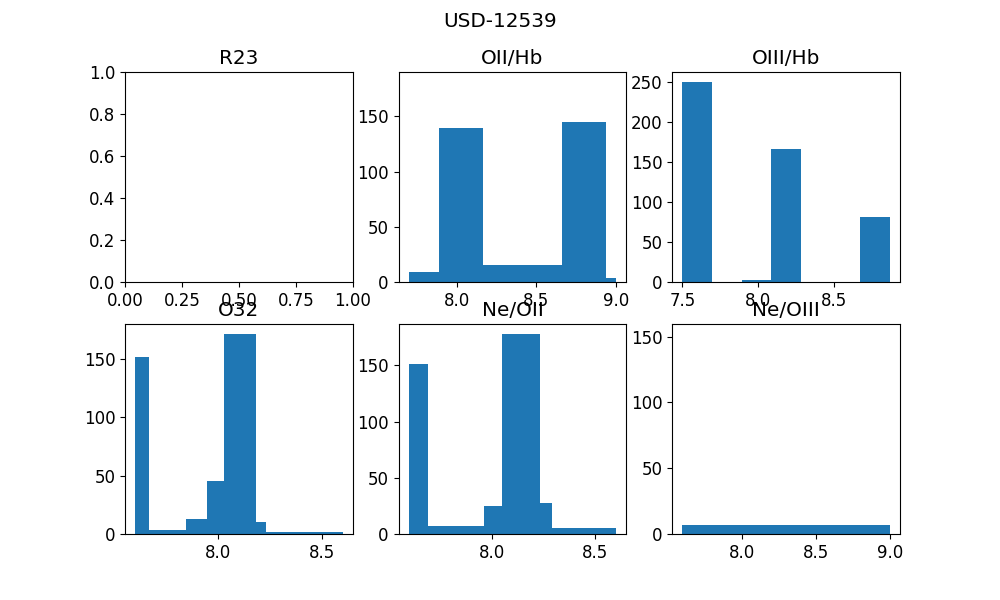

R23 not available


<IPython.core.display.Javascript object>


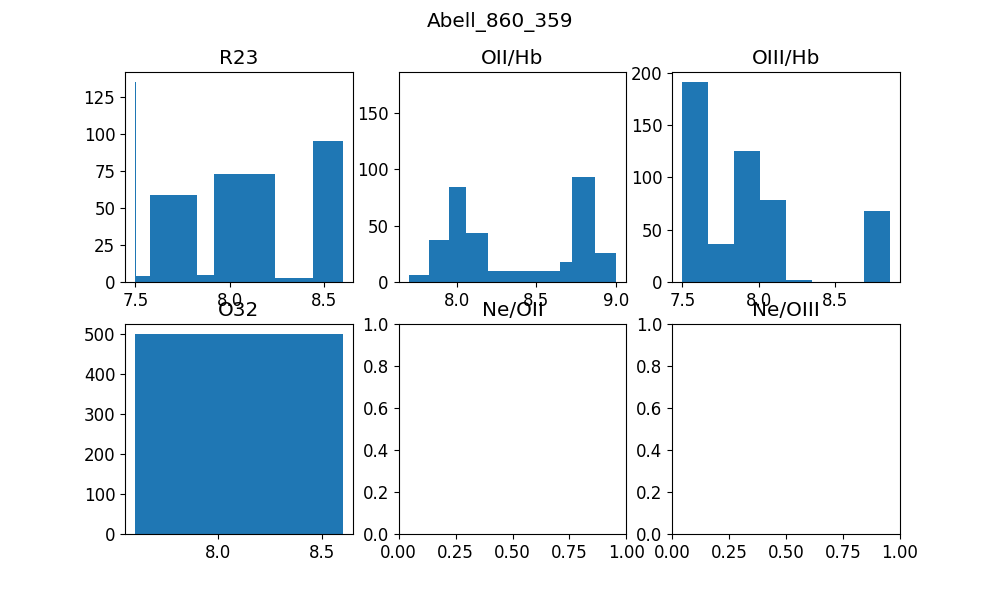

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


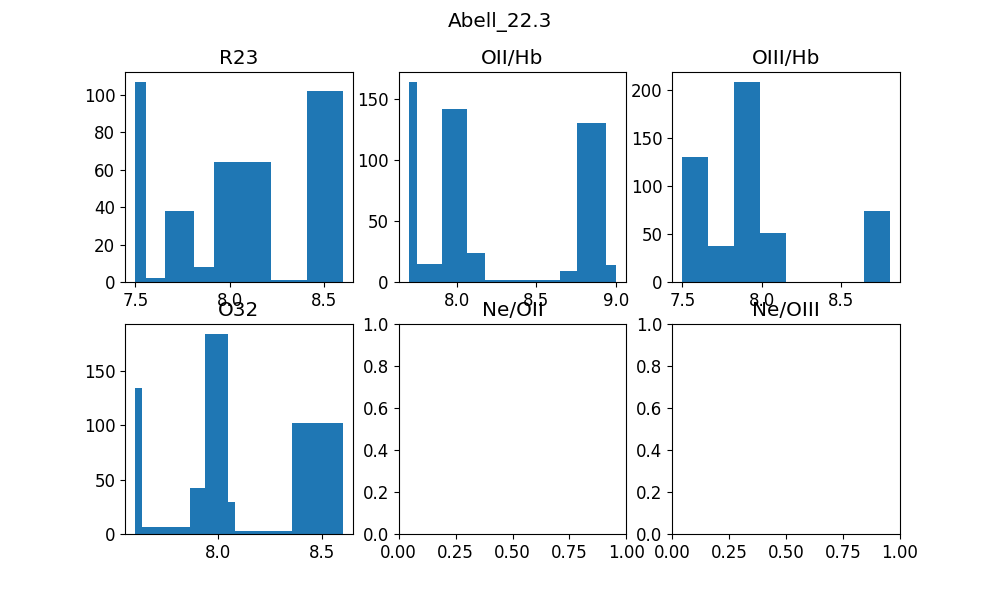

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


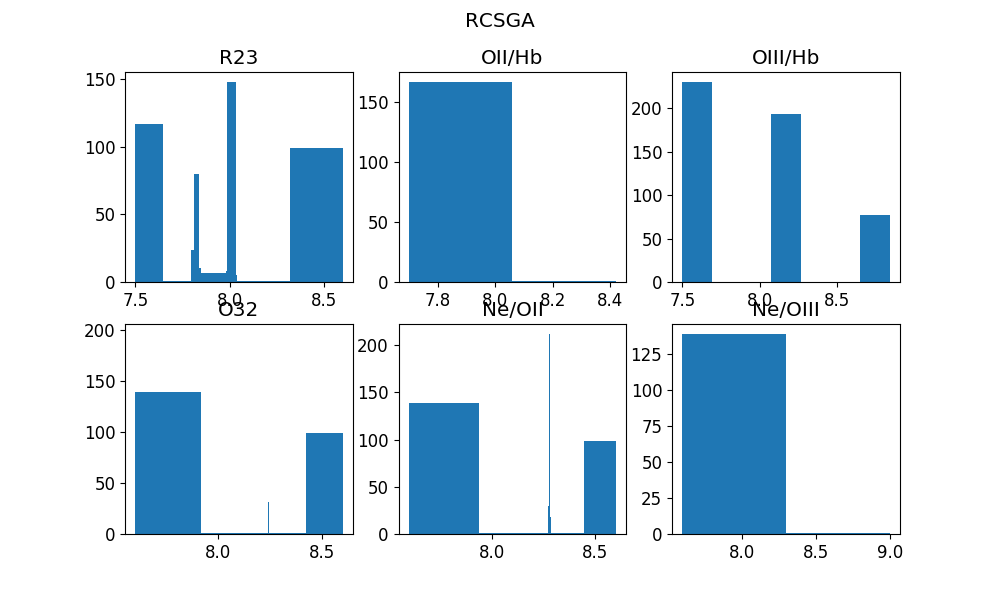

<IPython.core.display.Javascript object>


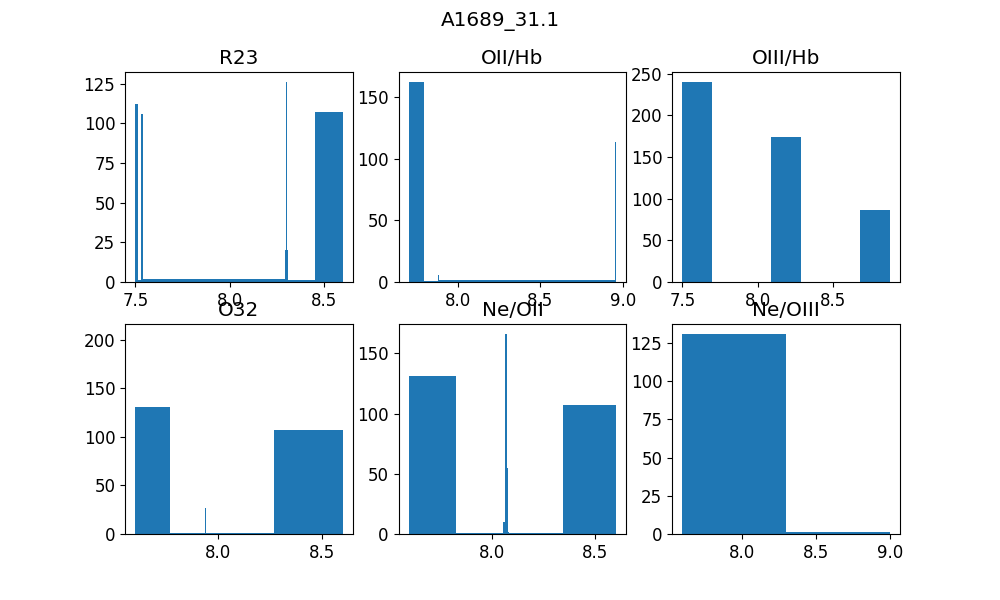

<IPython.core.display.Javascript object>


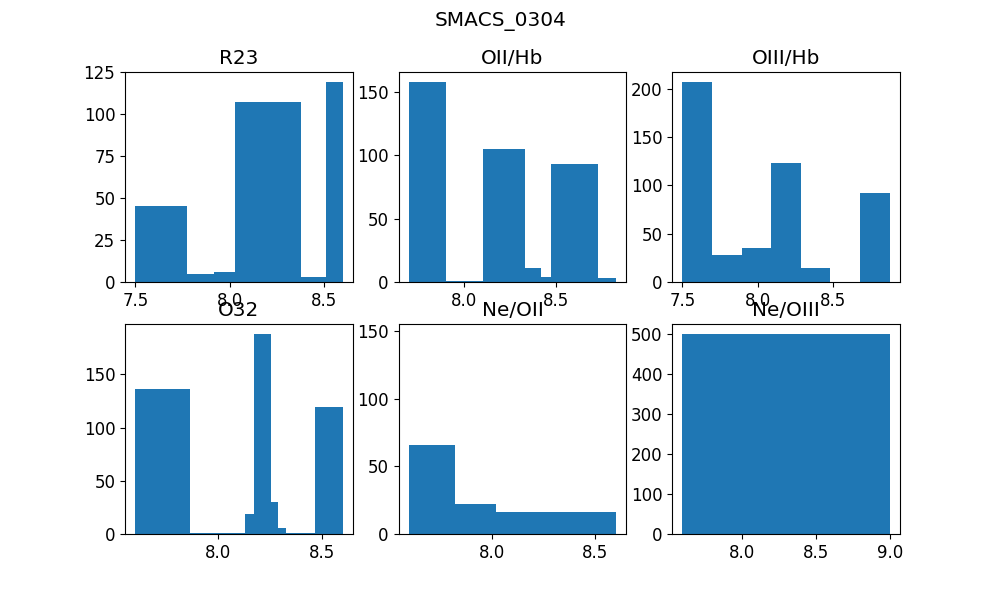

<IPython.core.display.Javascript object>


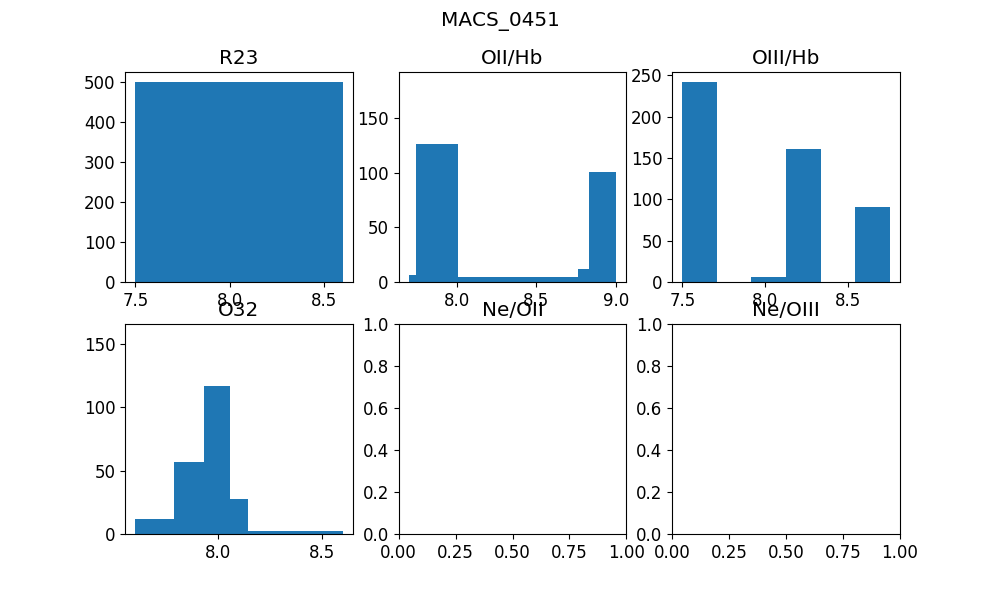

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


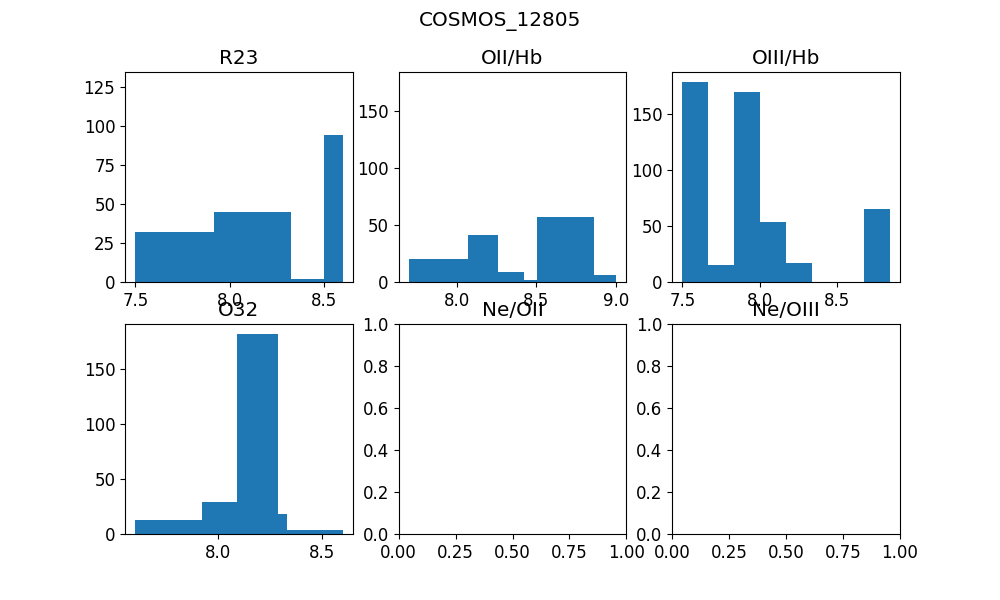

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


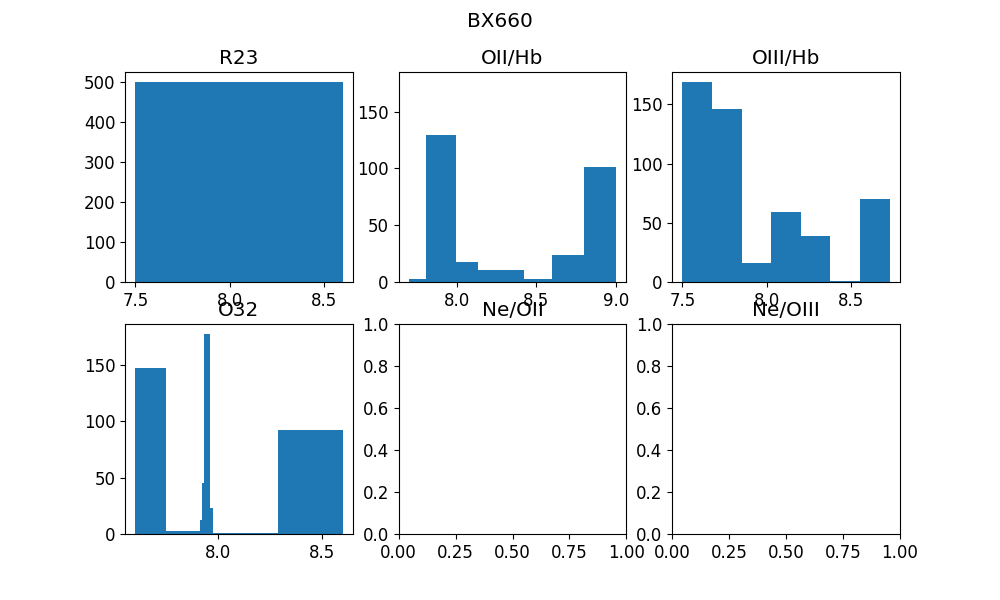

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


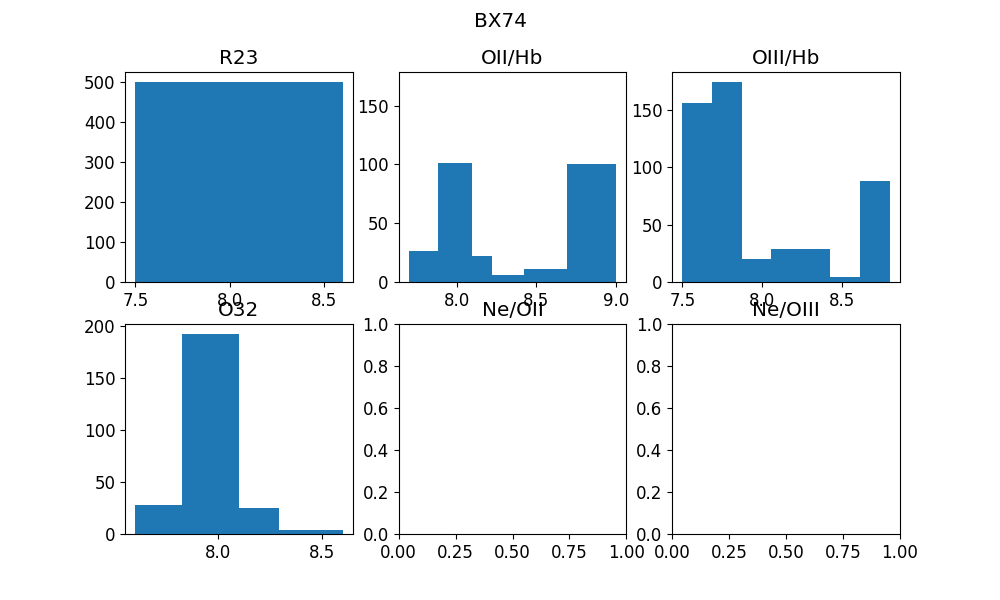

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


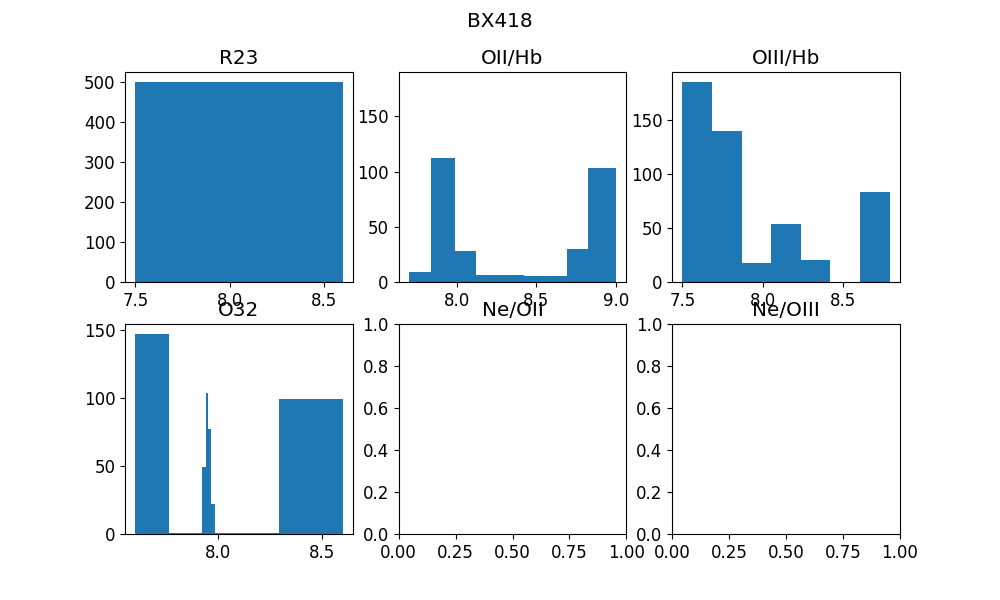

Ne_OII not available
Ne_OIII not available


<IPython.core.display.Javascript object>


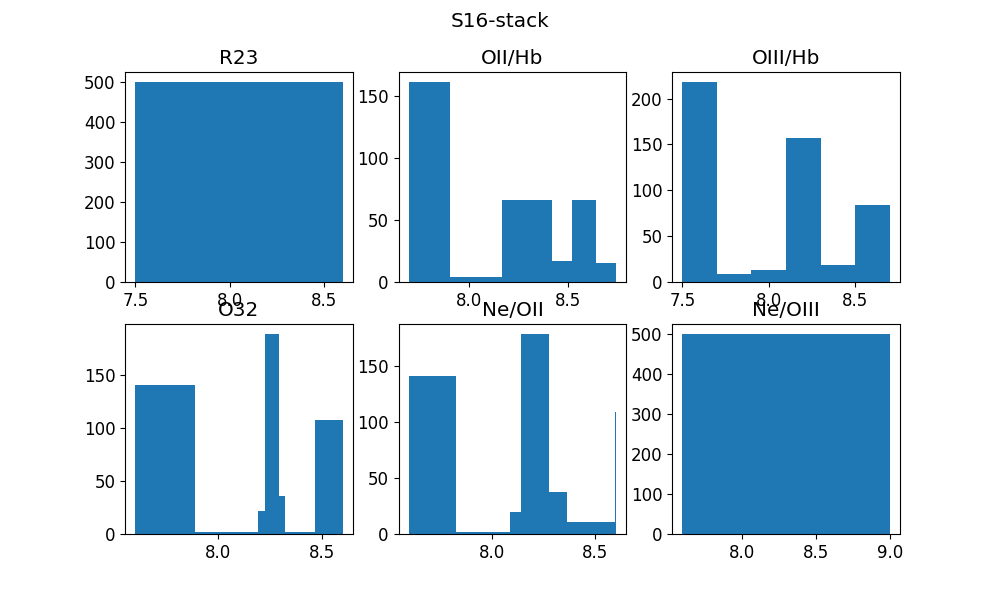

<IPython.core.display.Javascript object>


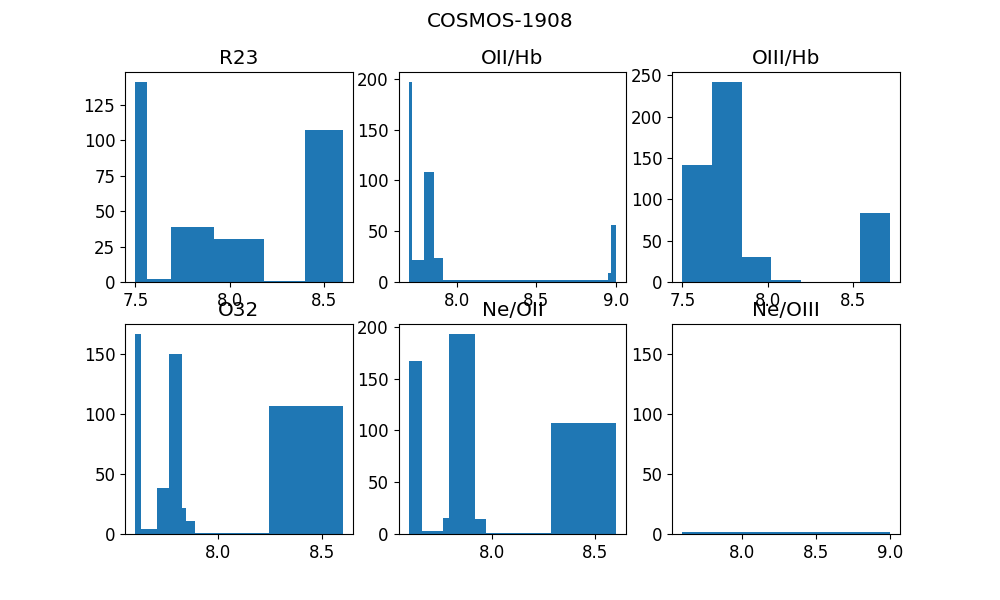

<IPython.core.display.Javascript object>


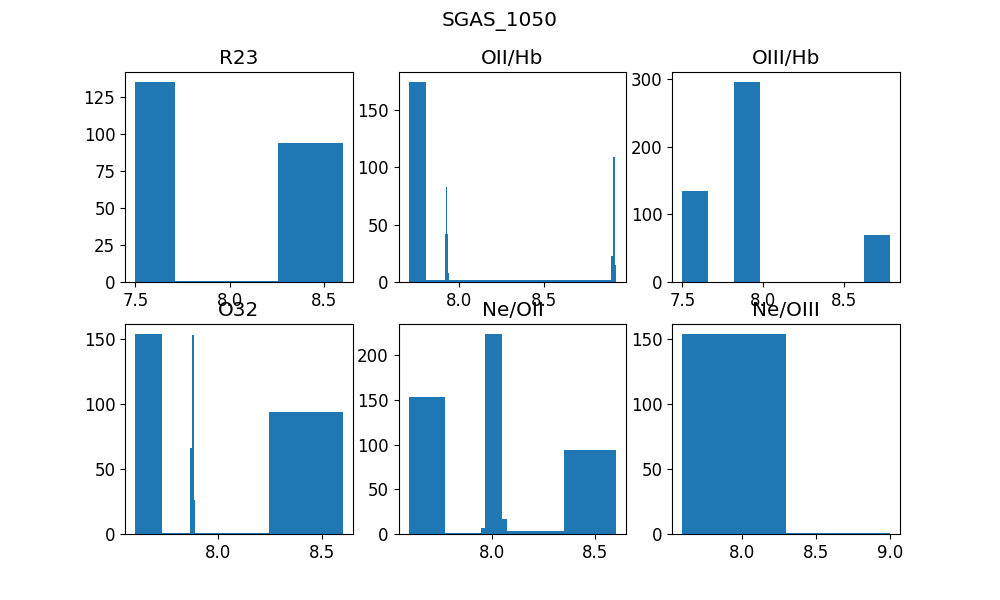

In [9]:
# Data
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')


#Initialise table to save results
jones15 = Table(names=['Name','R23','OIII_Hb','O32','OII_Hb','Ne_OII','Ne_OIII',
                             'upR23','upOIII_Hb','upO32','upOII_Hb','upNe_OII','upNe_OIII',
                             'lowR23','lowOIII_Hb','lowO32','lowOII_Hb','lowNe_OII','lowNe_OIII'],
                          dtype=('S15', 'f4', 'f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4',
                                 'f4','f4','f4','f4', 'f4','f4'))

for f_init in dered_fluxes:
    
    R23_sample = []
    OIII_Hb_sample = []
    O32_sample = []
    OII_Hb_sample =[]
    Ne_OII_sample =[]
    Ne_OIII_sample =[]
    
    for i in range(MC_steps):
        
        init_met = np.random.uniform(low=7.0,high=9.0)
        f = perturbed_lines(f_init)        

        params = Parameters()
        params.add('met', value=init_met, min=7.5, max=8.6) 

        ## R23
        R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
        if np.isfinite(R):
            fit = minimize(minimise_func, params,args=(R,R23_Jones15))
            R23_sample.append(fit.params['met'].value)    

        ## OIII/Hb
        R = f['OIII5007']/f['Hb']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.5, max=8.70) 
            fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Jones15))
            OIII_Hb_sample.append(fit.params['met'].value)            

        ## O32
        R = f['OIII5007']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.6, max=8.6)
            fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Jones15))
            O32_sample.append(fit.params['met'].value)
  
        ## OII/Hb
        R = f['OIITot']/f['Hb']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.7, max=9.0) 
            fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Jones15))
            OII_Hb_sample.append(fit.params['met'].value)

        ## Ne_OII_sample
        R = f['NeIII3869']/f['OIITot']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.6, max=8.6)
            fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Jones15))
            Ne_OII_sample.append(fit.params['met'].value)
            
            
        ## Ne_OIII_sample
        R = f['NeIII3869']/f['OIII5007']
        if np.isfinite(R):
            params['met'].set(value=init_met, min=7.6, max=9.0)
            fit = minimize(minimise_func, params,args=(R,NeIII_3870_OIII_5007_Jones15))
            Ne_OIII_sample.append(fit.params['met'].value)    
        
    # Some plots
    fig, ax = plt.subplots(2,3,figsize=(10,6))
    fig.suptitle(f_init['Name'])
    ax = ax.ravel()
    try: 
        hist(R23_sample,      bins='blocks',ax=ax[0]) 
    except (ValueError,IndexError):
        print('R23 not available')
    try:
        hist(OII_Hb_sample,   bins='blocks',ax=ax[1])
    except (ValueError,IndexError):
        print('OII_Hb not available')   
    try:
        hist(OIII_Hb_sample,  bins='blocks',ax=ax[2]) 
    except (ValueError,IndexError):
        print('OIII_Hb not available')   
    try:
        hist(O32_sample,      bins='blocks',ax=ax[3]) 
    except (ValueError,IndexError):
        print('O32_sample not available') 
    try:
        hist(Ne_OII_sample,   bins='blocks',ax=ax[4]) 
    except (ValueError,IndexError):
        print('Ne_OII not available') 
    try:
        hist(Ne_OIII_sample, bins='blocks',ax=ax[5]) 
    except (ValueError,IndexError):
        print('Ne_OIII not available') 
    
    
    ax[0].set_title('R23')
    ax[1].set_title('OII/Hb')
    ax[2].set_title('OIII/Hb')
    ax[3].set_title('O32')
    ax[4].set_title('Ne/OII')
    ax[5].set_title('Ne/OIII')
        
    # Save to table
    jones15.add_row((f_init['Name'],
        np.nanpercentile(R23_sample,50),
        np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(Ne_OIII_sample,50),
        np.nanpercentile(R23_sample,84)-np.nanpercentile(R23_sample,50),
        np.nanpercentile(OIII_Hb_sample,84)-np.nanpercentile(OIII_Hb_sample,50),
        np.nanpercentile(O32_sample,84)-np.nanpercentile(O32_sample,50),
        np.nanpercentile(OII_Hb_sample,84)-np.nanpercentile(OII_Hb_sample,50),
        np.nanpercentile(Ne_OII_sample,84)-np.nanpercentile(Ne_OII_sample,50),
        np.nanpercentile(Ne_OIII_sample,84)-np.nanpercentile(Ne_OIII_sample,50),
        np.nanpercentile(R23_sample,50)-np.nanpercentile(R23_sample,16),
        np.nanpercentile(OIII_Hb_sample,50)-np.nanpercentile(OIII_Hb_sample,16),
        np.nanpercentile(O32_sample,50)-np.nanpercentile(O32_sample,16),
        np.nanpercentile(OII_Hb_sample,50)-np.nanpercentile(OII_Hb_sample,16),
        np.nanpercentile(Ne_OII_sample,50)-np.nanpercentile(Ne_OII_sample,16),
        np.nanpercentile(Ne_OIII_sample,50)-np.nanpercentile(Ne_OIII_sample,16)))
                    
jones15.write('Metallicity_Jones15.dat',format='ascii.fixed_width_two_line')

### Plot

<IPython.core.display.Javascript object>


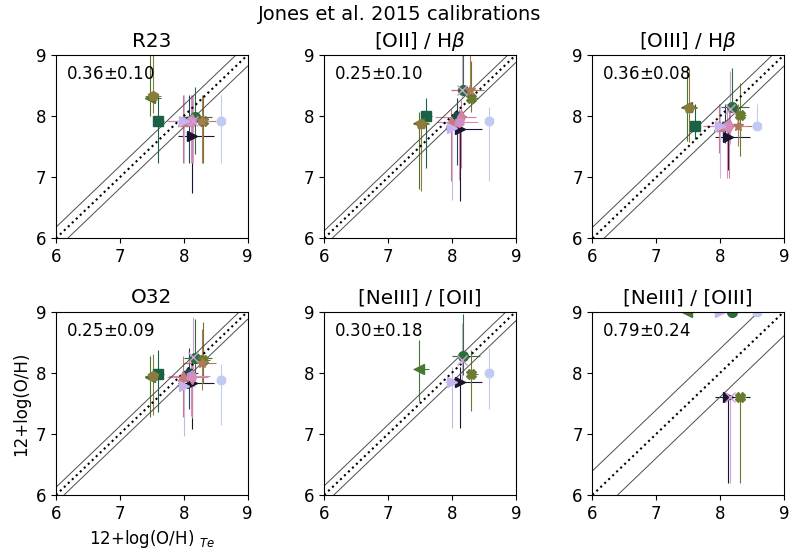

In [10]:
# Compare with the direct method
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
direct_Te.remove_row(1)
direct_Te.add_index('Name')
jones15 = Table.read('Metallicity_Jones15.dat',format='ascii.fixed_width_two_line')
jones15.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Save values to calculate stats
y = [] # obtainted metalliciity
w = [] # weights (uncertainties)
x = [] # predicted metallicity (Te)

# Fig
fig, ax = plt.subplots(2,3,figsize=(8,5.5))
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Jones et al. 2015 calibrations',fontsize=14,y=0.99)

ax = ax.ravel()
fig.subplots_adjust(top=0.90,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    
    met = jones15.loc[gal['Name']]
    
    ax[0].errorbar(gal['met'],met['R23'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upR23'],met['lowR23'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[1].errorbar(gal['met'],met['OII_Hb'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOII_Hb'],met['lowOII_Hb'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    ax[2].errorbar(gal['met'],met['OIII_Hb'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upOIII_Hb'],met['lowOIII_Hb'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[3].errorbar(gal['met'],met['O32'],  
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upO32'],met['lowO32'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8)     
    ax[4].errorbar(gal['met'],met['Ne_OII'], 
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNe_OII'],met['lowNe_OII'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
    ax[5].errorbar(gal['met'],met['Ne_OIII'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=np.array((met['upNe_OIII'],met['lowNe_OIII'])).reshape(2,1),
                   marker=m,color=c,markersize=7,elinewidth=0.8) 
         
    # Save results  
    x.append((gal['met'],gal['met'],gal['met'],gal['met'],gal['met'],gal['met'])) # could be prettier
    y.append((met['R23'],met['OII_Hb'],met['OIII_Hb'],met['O32'],met['Ne_OII'],met['Ne_OIII']))
    w.append((met['upR23']+met['lowR23']+gal['lowmet']+gal['upmet'],
              met['upOII_Hb']+met['lowOII_Hb']+gal['lowmet']+gal['upmet'],
              met['upOIII_Hb']+met['lowOIII_Hb']+gal['lowmet']+gal['upmet'],
              met['upO32']+met['lowO32']+gal['lowmet']+gal['upmet'],
              met['upNe_OII']+met['lowNe_OII']+gal['lowmet']+gal['upmet'],
              met['upNe_OIII']+met['lowNe_OIII']+gal['lowmet']+gal['upmet']))
 

# fix data format
y = np.array(y).T
w = np.array(w).T
x = np.array(x).T
d = []
e = []

# set limits, 1:1 relation and stats
for i in range(6):
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5),color='k',linewidth=1.5,linestyle=':')
    ax[i].set_ylim(6.0,9.0)
    ax[i].set_xlim(6.0,9.0)

    # Stats
    wght = np.array(w[i][~np.isnan(y[i])])
    data = np.array(y[i][~np.isnan(y[i])])
    pred = np.array(x[i][~np.isnan(y[i])])
    mae, emae = mean_absolute_error(pred,data,sample_weight=1./wght),1./np.sum(1./wght)
    #ax[i].annotate('$\\bar{x}$: %0.2f\n$\sigma$: %0.2f'%(np.nanmean(data-pred),np.nanstd(data-pred)),xy=(10,-1.8))
    ax[i].annotate('%0.2f$\pm$%0.2f'%(mae, emae),xy=(6.15,8.6))
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5)+mae/2.,color='0.3',linewidth=0.7,linestyle='-')
    ax[i].plot(np.arange(6.0,9.5),np.arange(6.0,9.5)-mae/2.,color='0.3',linewidth=0.7,linestyle='-')
    d.append(mae)
    e.append(emae)

# Set titles
ax[0].set_title('R23')
ax[1].set_title('[OII] / H$\\beta$')
ax[2].set_title('[OIII] / H$\\beta$')
ax[3].set_title('O32')
ax[4].set_title('[NeIII] / [OII]')
ax[5].set_title('[NeIII] / [OIII]')
ax[3].set_xlabel('12+log(O/H) $_{Te}$')
ax[3].set_ylabel('12+log(O/H)')

#Save to Table 
jones15.add_row({'Name':'MAE',
                 'R23':d[0],'OII_Hb':d[1],'OIII_Hb':d[2],'O32':d[3],'Ne_OII':d[4],'Ne_OIII':d[5],
                 'upR23':e[0],'upOII_Hb':e[1],'upOIII_Hb':e[2],'upO32':e[3],'upNe_OII':e[4],'upNe_OIII':e[5]})

jones15.write('Metallicity_Jones15.dat',format='ascii.fixed_width_two_line')
fig.savefig('/Users/vera/Desktop/jones.pdf')

## HII-CHI-mistry

From the website:
>These files represent the whole set of models, limiting the values of log U at each Z (left picture), and limiting also the values of N/O, respectively (right picture).
All were calculated with Cloudy v.13 and a POPSTAR SED at an age of 1Myr with an IMF of Chabrier.


HII-CHI-mistry has two codes: one for UV and other for optical, which means may be a problem:

Optical:
    * [OII] 3727/Hbeta
    * [OIII] 4363/Hbeta
    * [OIII] 5007/Hbeta
    * [NII] 6584/Hbeta
    * [SII] 6717+6731/Hbeta

UV:
    * Lya HI 1216
    * CIV    1549
    * OIII]  1665
    * CIII   1909
    * Hb HI  4861
    * [OIII] 5007


In [31]:
## Save files in the HII-CHI-mistry format: text file with 5 columns with extinction corrected fluxes
def err_ratio(x,y,e_x,e_y):
    """ Formal Error of x/y """
    return x/y * np.sqrt((e_x/x)**2 + (e_y/y)**2)

dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')

for gal in dered_fluxes:
    #UV
    f = open('CHImistry/'+gal['Name']+'_UV.dat','w')
    f.write('%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f'%
            # Lya   CIV   OIII]                                                             CIII  Hb
            (0.,0.,0.,0.,gal['OIII1661']+gal['OIII1666'],gal['eOIII1661']+gal['eOIII1666'],0.,0.,gal['Hb'],gal['eHb'],
            #[OIII]5007
             gal['OIII5007'],gal['eOIII5007']))
    f.close()        
    # Optical
    f = open('CHImistry/'+gal['Name']+'_Optical.dat','w')
    f.write('%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f'%
             #[OII] 3727/Hbeta  
             (gal['OII3727']/gal['Hb'],err_ratio(gal['OII3727'],gal['Hb'],gal['eOII3727'],gal['eHb']),
             # [OIII] 4363/Hbeta 
             gal['OIII4363']/gal['Hb'],err_ratio(gal['OIII4363'],gal['Hb'],gal['eOIII4363'],gal['eHb']),
             # [OIII] 5007/Hbeta    
             gal['OIII5007']/gal['Hb'],err_ratio(gal['OIII5007'],gal['Hb'],gal['eOIII5007'],gal['eHb']),                                  
             # [NII] 6584/Hbeta  
             gal['NII6584']/gal['Hb'],err_ratio(gal['NII6584'],gal['Hb'],gal['eNII6584'],gal['eHb']),                                    
             # [SII] 6717+6731/Hbeta
             0.0,0.0))
    f.close()   

In [32]:
## For optical lines
import glob
from HCm_v3_less_verbose import HII_CHIm

MetOH = []
eMetOH = []
MetNO = []
eMetNO =[]
U = []
eU = []

for inputfile in glob.glob('CHImistry/*_Optical.dat'):
    iMetOH,ieMetOH,iMetNO,ieMetNO,iU,ieU = HII_CHIm(0,inputfile,inputfile.replace('.dat','_out'))
    MetOH.append(iMetOH)
    eMetOH.append(ieMetOH)
    MetNO.append(iMetNO)
    eMetNO.append(iMetNO)
    U.append(iU)
    eU.append(ieU)

---------------------------------------------------------------------
Reading file CHImistry/A1689_31.1_Optical.dat
No interpolation for the models are going to be used.
The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 1  7.497 0.103  -10.0 0.0  -1.875 0.003
---------------------------------------------------------------------
Reading file CHImistry/Abell_22.3_Optical.dat
No interpolation for the models are going to be used.
The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 1  7.613 0.201  -10.0 0.0  -2.04 0.133
-------

In [33]:
## Save results
HCm_out = Table([dered_fluxes['Name'],MetOH,eMetOH,MetNO,eMetNO,U,eU],
                names = ['Name','12+log(O/H)','err_OH','12+log(N/O)','err_NO','U','errU'])
HCm_out.write('Metallicity_HCmistry.dat',format='ascii.fixed_width_two_line')
HCm_out.show_in_notebook()      

<IPython.core.display.Javascript object>


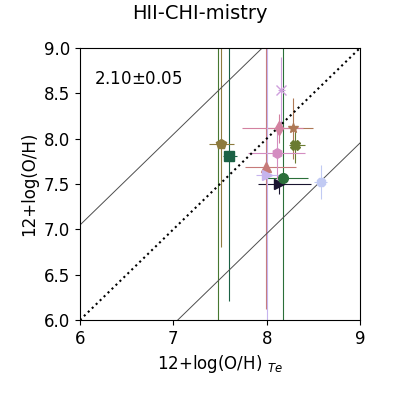

In [36]:
# Compare with the direct method
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
direct_Te.remove_row(1)
direct_Te.add_index('Name')
HCm = Table.read('Metallicity_HCmistry.dat',format='ascii.fixed_width_two_line')
HCm.add_index('Name')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Save values to calculate stats
y = [] # obtainted metalliciity
w = [] # weights (uncertainties)
x = [] # predicted metallicity (Te)

# Fig
fig, ax = plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(bottom=0.2,left=0.2)
fig.suptitle('HII-CHI-mistry',fontsize=14,y=0.99)

#fig.subplots_adjust(top=0.90,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))

for i,gal in enumerate(direct_Te):

    m = s.loc[gal['Name']]['marker']
    c = colors[s.loc[gal['Name']]['nb']]
    
    met = HCm.loc[gal['Name']]
    
    ax.errorbar(gal['met'],met['12+log(O/H)'],
                   xerr=np.array((gal['lowmet'],gal['upmet'])).reshape(2,1),
                   yerr=met['err_OH'],
                   marker=m,color=c,markersize=7,elinewidth=0.8)
    
    # Save results  
    x.append(gal['met']) # could be prettier
    y.append(met['12+log(O/H)'])
    w.append(met['err_OH']+gal['lowmet']+gal['upmet'])
 

# set limits, 1:1 relation and stats
ax.plot(np.arange(6.0,9.5),np.arange(6.0,9.5),color='k',linewidth=1.5,linestyle=':')
ax.set_ylim(6.0,9.0)
ax.set_xlim(6.0,9.0)
ax.set_xlabel('12+log(O/H) $_{Te}$')
ax.set_ylabel('12+log(O/H)')

# Stats
w= np.array(w)
mae, emae = mean_absolute_error(x,y,sample_weight=1./w),1./np.sum(1./w)
ax.annotate('%0.2f$\pm$%0.2f'%(mae, emae),xy=(6.15,8.6))
ax.plot(np.arange(6.0,9.5),np.arange(6.0,9.5)+mae/2.,color='0.3',linewidth=0.7,linestyle='-')
ax.plot(np.arange(6.0,9.5),np.arange(6.0,9.5)-mae/2.,color='0.3',linewidth=0.7,linestyle='-')


#Save to Table 
HCm.add_row({'Name':'MAE','12+log(O/H)':mae,'err_OH':emae})

HCm.write('Metallicity_HCmistry.dat',format='ascii.fixed_width_two_line')
fig.savefig('/Users/vera/Desktop/HCm.pdf')

In [94]:
# Prepare table for paper with summary
maiolino08 = Table.read('Metallicity_Maiolino08.dat',format='ascii.fixed_width_two_line')
maiolino08.add_index('Name')
m08 = maiolino08.loc['MAE']
curti16    = Table.read('Metallicity_Curti17.dat',format='ascii.fixed_width_two_line')
curti16.add_index('Name')
c16 = curti16.loc['MAE']
jones15    = Table.read('Metallicity_Jones15.dat',format='ascii.fixed_width_two_line')
jones15.add_index('Name')
j15 = jones15.loc['MAE']

calibs = ['R23','NII_Ha',"OIII_Hb","O32","OII_Hb","OIII_NII","Ne_OII"]

for calib in calibs:
    
    a,b = m08[calib],m08['up'+calib]

    try:
        c,d = c16[calib],c16['up'+calib]
    except KeyError:
        c,d = 99 ,99  
    
    try:
        e,f = j15[calib],j15['up'+calib]
    except KeyError:
        e,f = 99, 99     
    
    print('%s & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f & %0.2f$\pm$%0.2f \\\\'%(calib,a,b,c,d,e,f))

R23 & 0.25$\pm$0.03 & 0.28$\pm$0.03 & 0.36$\pm$0.10 \\
NII_Ha & 0.22$\pm$0.07 & 0.21$\pm$0.10 & 99.00$\pm$99.00 \\
OIII_Hb & 0.31$\pm$0.07 & 0.26$\pm$0.02 & 0.36$\pm$0.08 \\
O32 & 0.44$\pm$0.03 & 0.47$\pm$0.04 & 0.25$\pm$0.09 \\
OII_Hb & 0.40$\pm$0.03 & 0.22$\pm$0.07 & 0.25$\pm$0.10 \\
OIII_NII & 0.17$\pm$0.09 & 0.30$\pm$0.12 & 99.00$\pm$99.00 \\
Ne_OII & 0.49$\pm$0.07 & 99.00$\pm$99.00 & 0.30$\pm$0.18 \\


In [85]:
m08

<Row index=15>
 Name      R23           NII_Ha        OIII_Hb          O32           OII_Hb        OIII_NII        Ne_OII          upR23          upNII_Ha       upOIII_Hb         upO32          upOII_Hb       upOIII_NII       upNe_OII     lowR23 lowNII_Ha lowOIII_Hb  lowO32 lowOII_Hb lowOIII_NII lowNe_OII
str13    float64        float64        float64        float64        float64        float64        float64         float64         float64         float64         float64         float64         float64         float64     float64  float64   float64   float64  float64    float64    float64 
----- -------------- -------------- -------------- -------------- -------------- -------------- -------------- --------------- --------------- --------------- --------------- --------------- --------------- --------------- ------- --------- ---------- ------- --------- ----------- ---------
  MAE 0.248980932867 0.218040315091 0.305237086096 0.435974074302 0.404794462133 0.167216107365 0.493455077542 0.0313178793408 0.0735125602838 0.0684997079812 0.0304888701177 0.0310252768434 0.0878317324681 0.0665597088702     0.0       0.0        0.0     0.0       0.0         0.0       0.0

# Just comparing line ratios with metallicity

In [9]:
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
direct_Te.show_in_notebook()

<IPython.core.display.Javascript object>


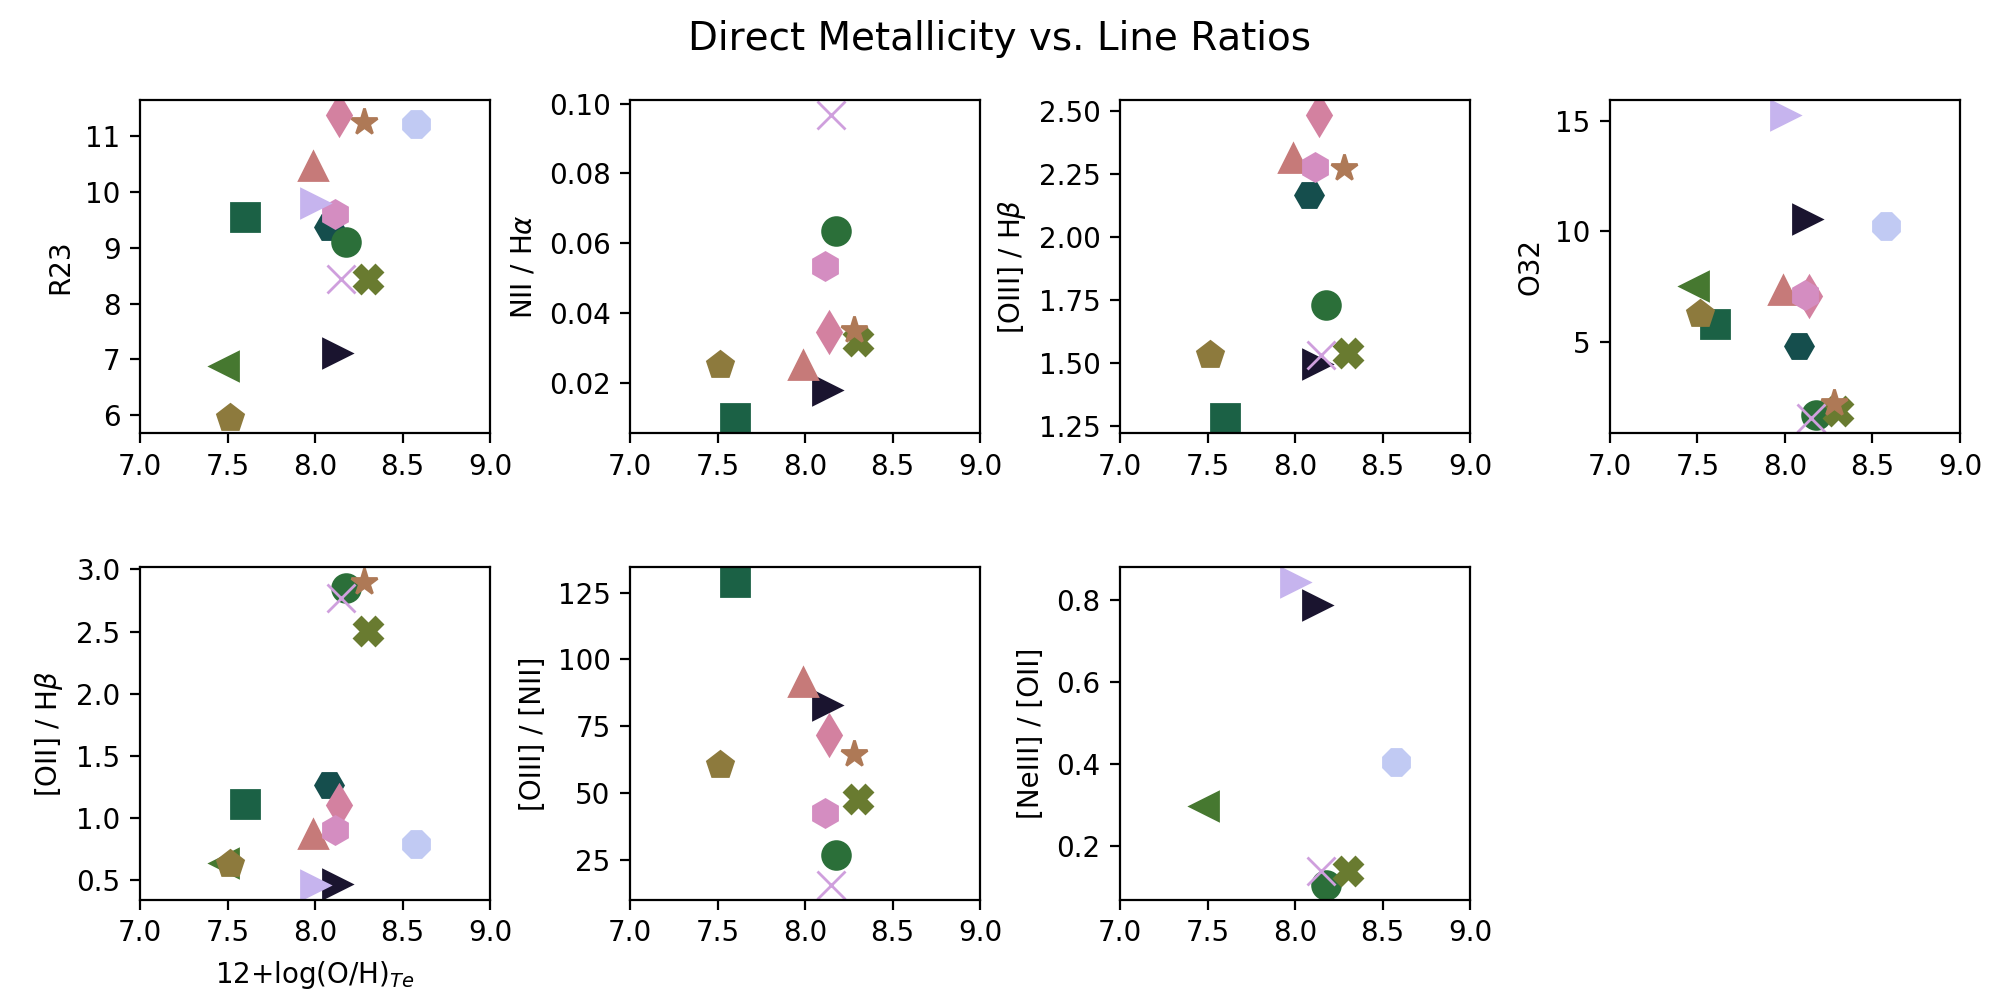

('CSWA20', 'CSWA20')
('USD-12539', 'USD-12539')
('Abell_860_359', 'Abell_860_359')
('Abell_22.3', 'Abell_22.3')
('RCSGA', 'RCSGA')
('A1689_31.1', 'A1689_31.1')
('SMACS_0304', 'SMACS_0304')
('MACS_0451', 'MACS_0451')
('COSMOS_12805', 'COSMOS_12805')
('BX660', 'BX660')
('BX74', 'BX74')
('BX418', 'BX418')
('S16-stack', 'S16-stack')
('COSMOS-1908', 'COSMOS-1908')
('SGAS_1050', 'SGAS_1050')


In [35]:
## Compare with direct method
import scipy as sci


# Data
direct_Te = Table.read('../TeMethod/pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
dered_fluxes = Table.read('../TeMethod/data_dered.dat',format='ascii.fixed_width_two_line')
s = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') 
s.add_index('Name')

# Fig
fig, ax = plt.subplots(2,4,figsize=(10,5))
fig.suptitle('Direct Metallicity vs. Line Ratios',fontsize=14)
ax = ax.ravel()
fig.subplots_adjust(top=0.90,bottom=0.1,right=0.98,left=0.07,hspace=0.4,wspace=0.4)
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(s['Name'])))
plt.rcParams.update({'font.size': 10})


for i,(gal,f) in enumerate(zip(direct_Te,dered_fluxes)):

    print(gal['Name'],f['Name'])
    m = s.loc[f['Name']]['marker']
    c = colors[s.loc[f['Name']]['nb']]
    
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    ax[0].plot(gal['met'],R, marker=m,color=c,markersize=10)
    
    R = f['NII6584']/f['Ha']
    ax[1].plot(gal['met'],R, marker=m,color=c,markersize=10)
    
    R = f['OIII5007']/f['Ha']
    ax[2].plot(gal['met'],R, marker=m,color=c,markersize=10)
    
    R = f['OIII5007']/f['OIITot']
    ax[3].plot(gal['met'],R, marker=m,color=c,markersize=10)
    
    R = f['OIITot']/f['Hb']
    ax[4].plot(gal['met'],R, marker=m,color=c,markersize=10)
    
    R = f['OIII5007']/f['NII6584']
    ax[5].plot(gal['met'],R,marker=m,color=c,markersize=10)
    
    R = f['NeIII3869']/f['OIITot']
    ax[6].plot(gal['met'],R,  marker=m,color=c,markersize=10)
 
    # just for labels
    ax[7].plot(np.nan,np.nan,label=gal['Name'],marker=m,color=c,markersize=7,linewidth=0.)

# set limits and 1:1 ralation
for x in ax[0:7]:
    #x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
    #x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
    #x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
    #x.set_ylim(7.0,9.0)
    x.set_xlim(7.0,9.0)
    #x.set_yscale('log')

ax[4].set_xlabel('12+log(O/H)$_{Te}$')

    
# Set titles
ax[0].set_ylabel('R23')
ax[1].set_ylabel('NII / H$\\alpha$')
ax[2].set_ylabel('[OIII] / H$\\beta$')
ax[3].set_ylabel('O32')
ax[4].set_ylabel('[OII] / H$\\beta$')
ax[5].set_ylabel('[OIII] / [NII]')
ax[6].set_ylabel('[NeIII] / [OII]')

ax[7].axis('off')
#ax[7].legend(loc=1,fontsize=8)

fig.savefig('/Users/vera/Desktop/DirectMet_LineRatios.pdf')